In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from plotly.offline import plot, iplot, init_notebook_mode
%pip install xgboost

warnings.filterwarnings("ignore")

In [ ]:
# download the data from github
!wget https://github.com/andre-brandao/puc_zoonotic_capacity/blob/master/input/MammalTrainingData080221_NvAdded.csv
!wget https://github.com/andre-brandao/puc_zoonotic_capacity/blob/master/input/MammalPredictionData231220_wildCategory.csv

--2024-05-21 22:36:47--  https://github.com/andre-brandao/puc_zoonotic_capacity/blob/master/input/MammalTrainingData080221_NvAdded.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘MammalTrainingData080221_NvAdded.csv.1’

MammalTrainingData0     [ <=>                ] 233.31K  --.-KB/s    in 0.04s   

2024-05-21 22:36:47 (5.98 MB/s) - ‘MammalTrainingData080221_NvAdded.csv.1’ saved [238906]

--2024-05-21 22:36:47--  https://github.com/andre-brandao/puc_zoonotic_capacity/blob/master/input/MammalPredictionData231220_wildCategory.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘MammalPredictionData231220_wildCategory.csv’

MammalPredictionDat     [ <=>             

In [ ]:
# Read the data
#data = pd.read_csv('/content/drive/MyDrive/covid_colab/MammalTrainingData080221_NvAdded.csv')
data = pd.read_csv('./MammalTrainingData080221_NvAdded.csv')
data

,Species,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,male_maturity_d,weaning_d,litters_or_clutches_per_y,...,Proboscidea,Rodentia,Sirenia,Soricomorpha,Tubulidentata,nchar,haddock_score_mean,haddock_score_sd,AA_83_Y,AA_30_negative
0,Neovison vison,1.0,0.0,1.0,1.0,0.0,297.722620,371.000000,49.000000,1.000000,...,0,0,0,0,0,805,-144.814760,1.580668,1,1
1,Acinonyx jubatus,1.0,0.0,0.0,0.0,1.0,598.985000,456.000000,107.000000,0.700000,...,0,0,0,0,0,805,-127.078110,1.747960,1,1
2,Aotus nancymaae,1.0,0.0,1.0,0.0,0.0,683.548198,627.229743,199.718698,1.373433,...,0,0,0,0,0,805,-140.619180,2.629311,1,1
3,Balaenoptera acutorostrata,0.0,1.0,0.0,0.0,1.0,2740.000000,2740.000000,167.340000,1.000000,...,0,0,0,0,0,804,-117.739420,2.003812,1,0
4,Bos mutus,NaN,NaN,NaN,NaN,NaN,494.972661,702.981099,90.199617,1.068823,...,0,0,0,0,0,804,-128.363990,2.843593,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,Ursus arctos,1.0,0.0,0.0,1.0,1.0,1320.475000,1313.000000,213.000000,0.400000,...,0,0,0,0,0,805,-164.694640,3.378159,1,1
109,Ursus maritimus,1.0,0.0,0.0,1.0,1.0,1734.000000,1734.000000,326.440000,0.400000,...,0,0,0,0,0,790,-148.124260,2.376873,1,1
110,Vombatus ursinus,1.0,0.0,1.0,0.0,0.0,742.575000,730.000000,398.725000,0.770000,...,0,0,0,0,0,809,-125.032739,3.420254,0,1
111,Vulpes vulpes,1.0,0.0,1.0,1.0,0.0,304.000000,304.000000,49.710000,1.000000,...,0,0,0,0,0,804,-141.373520,4.313306,1,1


In [ ]:
# binarize haddock score column if the score is lower than (-129) then 1 else 0
# 1 == higher binding strength
data['binary_haddock_score'] = np.where(data['haddock_score_mean'] < -129, 1, 0)

In [ ]:
# data is balanced
data['binary_haddock_score'].value_counts()

binary_haddock_score
1    58
0    55
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 82 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Species                           113 non-null    object 
 1   ForStrat_terrestrial              109 non-null    float64
 2   ForStrat_aquatic                  109 non-null    float64
 3   Activity.Nocturnal                109 non-null    float64
 4   Activity.Crepuscular              109 non-null    float64
 5   Activity.Diurnal                  109 non-null    float64
 6   female_maturity_d                 113 non-null    float64
 7   male_maturity_d                   113 non-null    float64
 8   weaning_d                         113 non-null    float64
 9   litters_or_clutches_per_y         113 non-null    float64
 10  longevity_y                       113 non-null    float64
 11  adult_svl_cm                      113 non-null    float64
 12  infantMo

In [ ]:
pd.set_option('display.max_rows', 500)    # adicionado para ver todos numeros nulos de cada atributo
pd.set_option('display.max_columns', 500) # adicionado para ver todos numeros nulos de cada atributo
data.isnull().sum()

Species                               0
ForStrat_terrestrial                  4
ForStrat_aquatic                      4
Activity.Nocturnal                    4
Activity.Crepuscular                  4
Activity.Diurnal                      4
female_maturity_d                     0
male_maturity_d                       0
weaning_d                             0
litters_or_clutches_per_y             0
longevity_y                           0
adult_svl_cm                          0
infantMortalityRate_per_year        107
mortalityRateDoublingTime_y         106
metabolicRate_W                      70
temperature_K                        59
diet_breadth                          4
development_d                         0
mass_specific_production              0
log_litterclutch_size_n               0
log_inter_litterbirth_interval_y      0
log_birthhatching_weight_g            0
log_weaning_weight_g                  0
log_adult_body_mass_g                 4
log_female_body_mass_g                0


In [ ]:
data = data.drop(['Species', 'haddock_score_mean', 'infantMortalityRate_per_year', 'mortalityRateDoublingTime_y',
                  'log_DispersalAge_d', 'log_PopulationGrpSize', 'X13.3_WeaningHeadBodyLen_mm', 'X24.1_TeatNumber',
                  ], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 74 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ForStrat_terrestrial              109 non-null    float64
 1   ForStrat_aquatic                  109 non-null    float64
 2   Activity.Nocturnal                109 non-null    float64
 3   Activity.Crepuscular              109 non-null    float64
 4   Activity.Diurnal                  109 non-null    float64
 5   female_maturity_d                 113 non-null    float64
 6   male_maturity_d                   113 non-null    float64
 7   weaning_d                         113 non-null    float64
 8   litters_or_clutches_per_y         113 non-null    float64
 9   longevity_y                       113 non-null    float64
 10  adult_svl_cm                      113 non-null    float64
 11  metabolicRate_W                   43 non-null     float64
 12  temperat

In [ ]:
# Removing outliers
def remove_out(df):
    mean = df.mean()
    std = df.std()
    std_size = 3
    outlier_mask = (np.abs(df - mean) <= std_size * std)
    cleaned_df = df[outlier_mask]
    return cleaned_df

cleaned_data = remove_out(data)
data = cleaned_data
data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,male_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,metabolicRate_W,temperature_K,diet_breadth,development_d,mass_specific_production,log_litterclutch_size_n,log_inter_litterbirth_interval_y,log_birthhatching_weight_g,log_weaning_weight_g,log_adult_body_mass_g,log_female_body_mass_g,log_male_body_mass_g,tnc_ecoregion_breadth,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.3_GR_MinLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X26.6_GR_MinLong_dd,X26.7_GR_MidRangeLong_dd,X27.4_HuPopDen_Change,X28.1_Precip_Mean_mm,X28.2_Temp_Mean_01degC,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_HomeRange_Indiv_km2,log_PopulationDensity_n.km2,log_HuPopDen_Min_n.km2,log_HuPopDen_Mean_n.km2,log_HuPopDen_5p_n.km2,log_NeonateHeadBodyLen_mm,log_WOS_hits,Afrosoricida,Artiodactyla,Carnivora,Cetacea,Chiroptera,Cingulata,Dasyuromorphia,Didelphimorphia,Diprotodontia,Erinaceomorpha,Lagomorpha,Macroscelidea,Monotremata,Perissodactyla,Pholidota,Primates,Proboscidea,Rodentia,Sirenia,Soricomorpha,Tubulidentata,nchar,haddock_score_sd,AA_83_Y,AA_30_negative,binary_haddock_score
0,1.0,0.0,1.0,1.0,0.0,297.722620,371.000000,49.000000,1.000000,10.695833,43.000000,2.7220,312.15,0.4,36.220620,0.045709,1.560248,-0.000685,2.156403,4.700480,6.802117,7.013985,7.444249,NaN,16.494735,NaN,36.705987,NaN,NaN,71.390000,24.940000,48.160000,-55.610000,-168.120000,-111.870000,0.030000,55.370000,14.910000,458.260000,529.250000,-2.866854,-2.754329,4.085635,1.056682,3.006178,0.025741,3.803203,7.557473,0.0,0.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,805.0,1.580668,1,1,1
1,1.0,0.0,0.0,0.0,1.0,598.985000,456.000000,107.000000,0.700000,19.000000,149.021500,61.7700,312.15,0.1,89.060000,0.019578,1.111858,0.395145,6.142747,7.570443,10.831270,9.846167,10.988802,0.309524,15.448508,9.03,92.240000,NaN,3.0,37.720000,-29.220000,4.240000,60.820000,-14.910000,22.950000,0.110000,51.260000,230.830000,595.060000,1499.040000,4.480400,4.547329,-4.605170,0.907587,2.989714,-0.067474,5.521461,6.694562,0.0,0.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,805.0,1.747960,1,1,0
2,1.0,0.0,1.0,0.0,0.0,683.548198,627.229743,199.718698,1.373433,11.391667,37.000000,NaN,NaN,0.6,127.745221,0.153402,0.019803,-0.116040,4.275836,6.129428,6.673336,7.444762,6.720834,0.083333,13.107712,NaN,108.672743,4.00,2.0,-2.720000,-6.470000,-4.590000,-66.610000,-75.950000,-71.280000,0.050000,228.040000,261.240000,1531.250000,1533.130000,-2.939557,-2.663378,3.337903,1.669032,0.122218,0.455452,4.046583,4.700481,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,0.0,805.0,2.629311,1,1,1
3,0.0,1.0,0.0,0.0,1.0,2740.000000,2740.000000,167.340000,1.000000,48.500000,NaN,NaN,NaN,0.2,309.306350,0.042667,0.000000,0.252002,12.676076,14.492895,15.830414,10.918308,14.592295,0.559524,18.728611,NaN,304.160000,2.00,3.0,11.659394,0.560051,6.201413,35.846219,14.805832,25.230358,NaN,148.434830,177.854437,894.442357,1307.267867,2.442211,-2.458595,-1.034633,1.632281,1.625241,0.654467,NaN,6.159096,0.0,0.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,804.0,2.003812,1,0,0
4,NaN,NaN,NaN,NaN,NaN,494.972661,702.981099,90.199617,1.068823,11.245579,38.234507,NaN,NaN,NaN,120.038185,0.407257,0.526610,-0.172863,2.924968,5.166991,NaN,5.248068,6.018212,0.047619,13.059399,NaN,108.754439,NaN,NaN,13.695438,-0.794176,6.201413,35.846219,14.805832,25.230358,NaN,149.293170,181.553030,875.991850,1326.443988,-1.319838,-2.781916,5.082738,1.847101,1.977512,0.721810,3.975580,3.663564,0.0,NaN,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,804.0,2.843593,1,1,0
5,1.0,0.0,0.0,0.0,1.0,477.000000,382.000000,62.000000,2.000000,16.250000,30.000000,0.8480,309.15,0.4,144.000000,0.476088,0.806476,-0.798280,3.300271,4.572647,5.542048,5.504163,5.768321,0.

In [ ]:
# Normalization (MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data = data_scaled
data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,male_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,metabolicRate_W,temperature_K,diet_breadth,development_d,mass_specific_production,log_litterclutch_size_n,log_inter_litterbirth_interval_y,log_birthhatching_weight_g,log_weaning_weight_g,log_adult_body_mass_g,log_female_body_mass_g,log_male_body_mass_g,tnc_ecoregion_breadth,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.3_GR_MinLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X26.6_GR_MinLong_dd,X26.7_GR_MidRangeLong_dd,X27.4_HuPopDen_Change,X28.1_Precip_Mean_mm,X28.2_Temp_Mean_01degC,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_HomeRange_Indiv_km2,log_PopulationDensity_n.km2,log_HuPopDen_Min_n.km2,log_HuPopDen_Mean_n.km2,log_HuPopDen_5p_n.km2,log_NeonateHeadBodyLen_mm,log_WOS_hits,Afrosoricida,Artiodactyla,Carnivora,Cetacea,Chiroptera,Cingulata,Dasyuromorphia,Didelphimorphia,Diprotodontia,Erinaceomorpha,Lagomorpha,Macroscelidea,Monotremata,Perissodactyla,Pholidota,Primates,Proboscidea,Rodentia,Sirenia,Soricomorpha,Tubulidentata,nchar,haddock_score_sd,AA_83_Y,AA_30_negative,binary_haddock_score
0,1.0,0.0,1.0,1.0,0.0,0.065797,0.075841,0.034741,0.210526,0.138029,0.067902,0.027137,0.864198,0.6,0.047435,0.064324,0.712741,0.625904,0.344187,0.255546,0.357657,0.497357,0.429557,NaN,0.741971,NaN,0.051922,NaN,NaN,0.901577,0.818372,0.941017,0.169165,0.036599,0.014533,0.200000,0.187966,0.194218,0.198967,0.104034,0.369099,0.349669,0.633553,0.514713,0.411510,0.162561,0.273348,0.655406,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.160701,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.144858,0.095436,0.104223,0.131579,0.269841,0.257353,0.627047,0.864198,0.0,0.164926,0.047067,0.510529,0.719685,0.573453,0.473731,0.635173,0.756037,0.687300,0.320513,0.647623,0.237632,0.170946,NaN,1.0,0.630613,0.250419,0.483326,0.579751,0.508595,0.528799,0.600000,0.170364,0.876430,0.288623,0.812691,0.870614,0.828728,0.024512,0.483852,0.409161,0.140070,0.565604,0.580571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.212083,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.167050,0.134908,0.215298,0.308798,0.149074,0.057181,NaN,NaN,1.0,0.250944,0.135447,0.018041,0.598573,0.466081,0.364180,0.348787,0.536702,0.376954,0.076923,0.436531,NaN,0.206166,0.046875,0.5,0.305167,0.488989,0.391309,0.130373,0.320548,0.169362,0.300000,0.927452,0.972512,0.902184,0.837602,0.364136,0.355636,0.581153,0.641462,0.000000,0.266244,0.314744,0.407636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.482780,1.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.706728,0.621946,0.176509,0.210526,0.738095,NaN,NaN,NaN,0.2,0.654653,0.062315,0.009111,0.685771,0.949202,1.000000,0.979500,0.853961,0.949329,0.589744,0.943420,NaN,0.625145,0.015625,1.0,0.420887,0.562710,0.503766,0.491682,0.600141,0.537498,NaN,0.586530,0.709050,0.484833,0.672557,0.731489,0.369072,0.274731,0.633855,0.214465,0.314263,NaN,0.534133,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341463,0.290665,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,0.117562,0.152370,0.084097,0.228638,0.146755,0.059387,NaN,NaN,NaN,0.233807,0.303096,0.246598,0.585111,0.388389,0.291012,NaN,0.336066,0.325862,0.038462,0.432175,NaN,0.206341,NaN,NaN,0.437272,0.548509,0.503766,0.491682,0.600141,0.537498,NaN,0.590206,0.720736,0.472741,0.686570,0.474696,0.347859,0.703429,0.678321,0.264731,0.330511,0.302667,0.317711,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341463,0.548594,1.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.112845,0.078377,0.050315,0.473684,0.226190,0.044673,0.008097,0.493827,0.6,0.287087,0.348554,0.372810,0.436935,0.409974,0.245827,0.270867,0.359456,0.307691,0.076923,0.495103,NaN,0.281881,0.117969,0.5,0.304684,0.447987,0

In [ ]:
# fill missing values with k-NN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data),columns = data.columns)
data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,male_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,metabolicRate_W,temperature_K,diet_breadth,development_d,mass_specific_production,log_litterclutch_size_n,log_inter_litterbirth_interval_y,log_birthhatching_weight_g,log_weaning_weight_g,log_adult_body_mass_g,log_female_body_mass_g,log_male_body_mass_g,tnc_ecoregion_breadth,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.3_GR_MinLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X26.6_GR_MinLong_dd,X26.7_GR_MidRangeLong_dd,X27.4_HuPopDen_Change,X28.1_Precip_Mean_mm,X28.2_Temp_Mean_01degC,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_HomeRange_Indiv_km2,log_PopulationDensity_n.km2,log_HuPopDen_Min_n.km2,log_HuPopDen_Mean_n.km2,log_HuPopDen_5p_n.km2,log_NeonateHeadBodyLen_mm,log_WOS_hits,Afrosoricida,Artiodactyla,Carnivora,Cetacea,Chiroptera,Cingulata,Dasyuromorphia,Didelphimorphia,Diprotodontia,Erinaceomorpha,Lagomorpha,Macroscelidea,Monotremata,Perissodactyla,Pholidota,Primates,Proboscidea,Rodentia,Sirenia,Soricomorpha,Tubulidentata,nchar,haddock_score_sd,AA_83_Y,AA_30_negative,binary_haddock_score
0,1.0,0.0,1.0,1.0,0.0,0.065797,0.075841,0.034741,0.210526,0.138029,0.067902,0.027137,0.864198,0.60,0.047435,0.064324,0.712741,0.625904,0.344187,0.255546,0.357657,0.497357,0.429557,0.487179,0.741971,0.571579,0.051922,0.009375,0.8,0.901577,0.818372,0.941017,0.169165,0.036599,0.014533,0.200000,0.187966,0.194218,0.198967,0.104034,0.369099,0.349669,0.633553,0.514713,0.411510,0.162561,0.273348,0.655406,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.160701,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.144858,0.095436,0.104223,0.131579,0.269841,0.257353,0.627047,0.864198,0.00,0.164926,0.047067,0.510529,0.719685,0.573453,0.473731,0.635173,0.756037,0.687300,0.320513,0.647623,0.237632,0.170946,0.245312,1.0,0.630613,0.250419,0.483326,0.579751,0.508595,0.528799,0.600000,0.170364,0.876430,0.288623,0.812691,0.870614,0.828728,0.024512,0.483852,0.409161,0.140070,0.565604,0.580571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.212083,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.167050,0.134908,0.215298,0.308798,0.149074,0.057181,0.019523,0.518519,1.00,0.250944,0.135447,0.018041,0.598573,0.466081,0.364180,0.348787,0.536702,0.376954,0.076923,0.436531,0.315316,0.206166,0.046875,0.5,0.305167,0.488989,0.391309,0.130373,0.320548,0.169362,0.300000,0.927452,0.972512,0.902184,0.837602,0.364136,0.355636,0.581153,0.641462,0.000000,0.266244,0.314744,0.407636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.365854,0.482780,1.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.706728,0.621946,0.176509,0.210526,0.738095,0.650588,0.540504,0.587654,0.20,0.654653,0.062315,0.009111,0.685771,0.949202,1.000000,0.979500,0.853961,0.949329,0.589744,0.943420,0.047526,0.625145,0.015625,1.0,0.420887,0.562710,0.503766,0.491682,0.600141,0.537498,0.570000,0.586530,0.709050,0.484833,0.672557,0.731489,0.369072,0.274731,0.633855,0.214465,0.314263,0.866916,0.534133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341463,0.290665,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.117562,0.152370,0.084097,0.228638,0.146755,0.059387,0.024461,0.397531,0.04,0.233807,0.303096,0.246598,0.585111,0.388389,0.291012,0.143948,0.336066,0.325862,0.038462,0.432175,0.165789,0.206341,0.026719,0.6,0.437272,0.548509,0.503766,0.491682,0.600141,0.537498,0.353527,0.590206,0.720736,0.472741,0.686570,0.474696,0.347859,0.703429,0.678321,0.264731,0.330511,0.302667,0.317711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341463,0.548594,1.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.112845,0.078377,0.050315,0.473684,0.226190,0.044673,0.008097,0.493827,0.60,0.287087,0.348554,0.372810,0.436935,0.40997

In [ ]:
# Attributes selection (39 escolhidos)
chosen_attributes = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 16, 18, 19, 22, 24, 25, 26, 27, 28, 29, 31, 32, 35, 38, 39,
                     40, 42, 46, 48, 55, 57, 59, 63, 64, 65, 67, 69, 73] #74, 75. Trocar 73 por 74 e adicionar 75

chosen_att = data.columns[chosen_attributes]
data = data.iloc[:, chosen_attributes]
data = data.drop(columns=['nchar']) # precisa dropar essa coluna porque não tem ela no dataset de 5000 instancias
print(chosen_att)
print(len(chosen_attributes))

Index(['ForStrat_terrestrial', 'ForStrat_aquatic', 'Activity.Nocturnal',
       'Activity.Crepuscular', 'Activity.Diurnal', 'female_maturity_d',
       'weaning_d', 'litters_or_clutches_per_y', 'longevity_y', 'adult_svl_cm',
       'development_d', 'log_litterclutch_size_n',
       'log_birthhatching_weight_g', 'log_weaning_weight_g',
       'log_male_body_mass_g', 'log_range_size', 'X2.1_AgeatEyeOpening_d',
       'X9.1_GestationLen_d', 'X10.2_SocialGrpSize', 'X6.2_TrophicLevel',
       'X26.2_GR_MaxLat_dd', 'X26.4_GR_MidRangeLat_dd', 'X26.5_GR_MaxLong_dd',
       'X27.4_HuPopDen_Change', 'X30.1_AET_Mean_mm', 'X30.2_PET_Mean_mm',
       'log_HomeRange_km2', 'log_PopulationDensity_n.km2',
       'log_NeonateHeadBodyLen_mm', 'Afrosoricida', 'Didelphimorphia',
       'Erinaceomorpha', 'Macroscelidea', 'Primates', 'Proboscidea',
       'Rodentia', 'Soricomorpha', 'nchar', 'binary_haddock_score'],
      dtype='object')
39


In [ ]:
# Instance selection
# train_split 54 instances, test_split 10/15%
chosen_instances   = [1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31,
                      32, 34, 36, 38, 39, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61,
                      62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 77, 78, 80, 81, 82]
print(len(chosen_instances))
#df_tmp = data
new_data = data.iloc[chosen_instances, :]
new_data

64


,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha,binary_haddock_score
1,1.0,0.0,0.0,0.0,1.0,0.144858,0.104223,0.131579,0.269841,0.257353,0.164926,0.510529,0.573453,0.473731,0.687300,0.647623,0.237632,0.170946,0.245312,1.0,0.630613,0.483326,0.579751,0.600000,0.288623,0.812691,0.870614,0.024512,0.565604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.706728,0.176509,0.210526,0.738095,0.650588,0.654653,0.009111,0.949202,1.000000,0.949329,0.943420,0.047526,0.625145,0.015625,1.0,0.420887,0.503766,0.491682,0.570000,0.484833,0.672557,0.731489,0.274731,0.866916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.117562,0.084097,0.228638,0.146755,0.059387,0.233807,0.246598,0.388389,0.291012,0.325862,0.432175,0.165789,0.206341,0.026719,0.6,0.437272,0.503766,0.491682,0.353527,0.472741,0.686570,0.474696,0.703429,0.302667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.112845,0.050315,0.473684,0.226190,0.044673,0.287087,0.372810,0.409974,0.245827,0.307691,0.495103,0.269579,0.281881,0.117969,0.5,0.304684,0.370571,0.242586,0.350000,0.496785,0.805070,0.297757,0.783887,0.376771,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,1.0,1.0,1.0,0.0,0.371078,0.104223,0.130263,0.380952,0.336369,0.516945,0.009111,0.712620,0.612956,0.635400,0.755294,0.000000,0.741588,0.149063,0.5,0.420094,0.503766,0.491682,0.540000,0.478088,0.685677,0.660577,0.549791,0.818692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,1.0,0.382625,0.600184,0.078947,0.825397,0.075302,0.327111,0.009111,0.533825,0.446166,0.452456,0.313670,0.290105,0.318445,0.267969,0.5,0.455979,0.530221,0.101315,0.750000,0.804520,0.935403,0.493127,0.578903,0.507612,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1.0,0.0,1.0,1.0,1.0,0.519384,0.413300,0.057895,0.682540,0.597435,0.291978,0.009111,0.843768,0.850214,0.949329,0.729050,0.269211,0.270552,0.336719,0.0,0.405440,0.334098,0.504673,0.600000,0.376792,0.783133,0.766093,0.294326,0.924352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,1.0,0.0,0.0,0.0,1.0,0.333776,0.364056,0.210526,0.396825,0.129372,0.338229,0.011360,0.580629,0.459195,0.567685,0.396577,0.290105,0.327061,0.531250,0.3,0.419524,0.521676,0.367599,0.450000,0.734525,0.853824,0.585693,0.500038,0.507769,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11,1.0,0.0,1.0,1.0,0.0,0.050649,0.040731,0.473684,0.240741,0.052267,0.215345,0.244413,0.431265,0.293958,0.326970,0.165851,0.480263,0.214304,0.032969,0.0,0.099791,0.122447,0.117290,0.250000,0.000000,0.565572,0.341715,0.828386,0.426831,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12,1.0,0.0,0.0,0.0,1.0,0.333776,0.230906,0.210526,0.455423,0.109001,0.333771,0.009111,0.552968,0.426058,0.519384,0.512665,0.290105,0.322150,0.440937,0.2,0.483985,0.570446,0.518391,0.700000,0.426017,0.826210,0.522494,0.579142,0.476663,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## **Models**

In [ ]:
y = new_data['binary_haddock_score']
x = new_data.drop(['binary_haddock_score'], axis=1)
x

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha
1,1.0,0.0,0.0,0.0,1.0,0.144858,0.104223,0.131579,0.269841,0.257353,0.164926,0.510529,0.573453,0.473731,0.687300,0.647623,0.237632,0.170946,0.245312,1.0,0.630613,0.483326,0.579751,0.600000,0.288623,0.812691,0.870614,0.024512,0.565604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.706728,0.176509,0.210526,0.738095,0.650588,0.654653,0.009111,0.949202,1.000000,0.949329,0.943420,0.047526,0.625145,0.015625,1.0,0.420887,0.503766,0.491682,0.570000,0.484833,0.672557,0.731489,0.274731,0.866916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.117562,0.084097,0.228638,0.146755,0.059387,0.233807,0.246598,0.388389,0.291012,0.325862,0.432175,0.165789,0.206341,0.026719,0.6,0.437272,0.503766,0.491682,0.353527,0.472741,0.686570,0.474696,0.703429,0.302667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.112845,0.050315,0.473684,0.226190,0.044673,0.287087,0.372810,0.409974,0.245827,0.307691,0.495103,0.269579,0.281881,0.117969,0.5,0.304684,0.370571,0.242586,0.350000,0.496785,0.805070,0.297757,0.783887,0.376771,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,0.0,0.371078,0.104223,0.130263,0.380952,0.336369,0.516945,0.009111,0.712620,0.612956,0.635400,0.755294,0.000000,0.741588,0.149063,0.5,0.420094,0.503766,0.491682,0.540000,0.478088,0.685677,0.660577,0.549791,0.818692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,1.0,0.382625,0.600184,0.078947,0.825397,0.075302,0.327111,0.009111,0.533825,0.446166,0.452456,0.313670,0.290105,0.318445,0.267969,0.5,0.455979,0.530221,0.101315,0.750000,0.804520,0.935403,0.493127,0.578903,0.507612,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,1.0,1.0,1.0,0.519384,0.413300,0.057895,0.682540,0.597435,0.291978,0.009111,0.843768,0.850214,0.949329,0.729050,0.269211,0.270552,0.336719,0.0,0.405440,0.334098,0.504673,0.600000,0.376792,0.783133,0.766093,0.294326,0.924352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,0.0,0.0,1.0,0.333776,0.364056,0.210526,0.396825,0.129372,0.338229,0.011360,0.580629,0.459195,0.567685,0.396577,0.290105,0.327061,0.531250,0.3,0.419524,0.521676,0.367599,0.450000,0.734525,0.853824,0.585693,0.500038,0.507769,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,1.0,0.0,1.0,1.0,0.0,0.050649,0.040731,0.473684,0.240741,0.052267,0.215345,0.244413,0.431265,0.293958,0.326970,0.165851,0.480263,0.214304,0.032969,0.0,0.099791,0.122447,0.117290,0.250000,0.000000,0.565572,0.341715,0.828386,0.426831,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12,1.0,0.0,0.0,0.0,1.0,0.333776,0.230906,0.210526,0.455423,0.109001,0.333771,0.009111,0.552968,0.426058,0.519384,0.512665,0.290105,0.322150,0.440937,0.2,0.483985,0.570446,0.518391,0.700000,0.426017,0.826210,0.522494,0.579142,0.476663,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.10, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((57, 37), (57,), (7, 37), (7,))

In [ ]:
x_train

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha
39,1.0,0.0,0.0,0.0,1.0,0.323250,0.290825,0.192105,0.564286,0.084253,0.333782,0.009111,0.552700,0.411110,0.512292,0.589836,0.322158,0.326225,0.406250,0.5,0.477145,0.482180,0.814190,0.650000,0.916478,0.974008,0.511782,0.621373,0.496249,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
52,1.0,0.0,1.0,1.0,1.0,0.059047,0.049040,0.302632,0.247619,0.197899,0.433841,0.079915,0.633015,0.559905,0.623510,0.536622,0.274632,0.423336,0.376094,0.0,0.587478,0.562005,0.787248,0.550000,0.615737,0.792742,0.648980,0.426975,0.597006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,1.0,0.0,0.0,0.0,1.0,0.006618,0.008721,0.498407,0.058069,0.017767,0.197533,0.274187,0.362599,0.151236,0.162185,0.352382,0.000000,0.209497,0.015625,0.7,0.093916,0.109942,0.458053,0.500000,0.143804,0.479448,0.251282,0.858342,0.321184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1.0,0.0,1.0,1.0,0.0,0.263138,0.361438,0.210526,0.620635,0.237490,0.211487,0.321702,0.636389,0.626649,0.667348,0.741357,0.000000,0.214004,0.125781,1.0,0.476662,0.385577,0.546567,0.700000,0.437500,0.850777,0.775560,0.198652,0.616084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,1.0,0.0,1.0,0.0,0.0,0.062459,0.304285,0.278947,0.430291,0.006344,0.387147,0.009111,0.339761,0.138667,0.143186,0.759631,0.013158,0.421943,0.009375,1.0,0.553356,0.403710,0.242586,0.550000,0.657019,0.784660,0.436106,0.734307,0.299681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,1.0,0.0,1.0,1.0,1.0,0.069085,0.041198,0.278947,0.144444,0.064232,0.059719,0.928473,0.349645,0.247215,0.386432,0.662106,0.765263,0.062176,0.032969,1.0,0.856108,0.936536,0.591494,0.077543,0.180276,0.116040,0.521451,0.334179,0.320677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,1.0,0.0,1.0,0.0,0.0,0.121748,0.019205,0.331523,0.111111,0.008398,0.200369,0.009111,0.332081,0.136332,0.148512,0.728117,0.213158,0.204659,0.032969,0.5,0.485112,0.421530,0.242586,0.650000,0.752220,0.849316,0.344578,0.659688,0.259348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,0.0,1.0,0.0,0.0,0.088795,0.140140,0.210526,0.264286,0.081822,0.262628,0.634292,0.461269,0.437658,0.486226,0.762044,0.000000,0.260448,0.000000,0.5,0.655722,0.485827,0.242586,0.550000,0.672998,0.775636,0.345070,0.558459,0.485793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,1.0,0.0,1.0,0.0,0.0,0.006276,0.002791,0.973684,0.093651,0.009061,0.023889,0.671602,0.256778,0.066038,0.113736,0.659369,0.342105,0.022911,0.029063,0.5,0.738532,0.788141,0.145537,0.300000,0.356003,0.416510,0.085067,0.857103,0.203005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
60,1.0,0.0,1.0,0.0,0.0,0.052040,0.006589,0.210526,0.428571,0.000482,0.091855,0.009111,0.262010,0.043818,0.062730,0.724754,0.013158,0.101397,0.000000,1.0,0.435036,0.503766,0.491682,0.500000,0.472109,0.692409,0.436106,0.776635,0.204971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_test

77    1.0
81    1.0
36    0.0
65    0.0
20    0.0
26    0.0
29    1.0
Name: binary_haddock_score, dtype: float64

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # random_state=2

In [ ]:
import copy
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold, StratifiedKFold

def perform_cross_validation(model, x, y, num_folds=10):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42) #random_state=2
    melhor = 0
    fold = 1
    labels = ['Não suceptível', 'Suceptível']
    labels2 = [0, 1]

    precision_valid = [0, 0]
    recall_valid = [0, 0]
    fscore_valid = [0, 0]

    best_model = None

    array_precision = []

    for train_index, valid_index in kf.split(x, y):
        x_train, x_valid = x.iloc[train_index], x.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model.fit(x_train, y_train)
        previsoes = model.predict(x_valid)

        # Calculating metrics
        precision, recall, fscore, support = precision_recall_fscore_support(y_valid, previsoes, average=None)

        precision_valid = np.add(precision_valid, precision)
        recall_valid = np.add(recall_valid, recall)
        fscore_valid = np.add(fscore_valid, fscore)

        accuracy = np.mean(y_valid == previsoes)

        if accuracy > melhor:
            melhor = accuracy
            best_model = copy.deepcopy(model)

        array_precision.append(accuracy)

        print('FOLD:', fold)
        print(metrics.classification_report(y_valid, previsoes, target_names=labels))

        cm = metrics.confusion_matrix(y_valid, previsoes, labels=labels2)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels2)
        disp.plot()
        plt.show()

        fold += 1
        print('---------------------------------------------------------')

    #plt.show(best_model)
    print("Precisão média na validação das classes Inferior e Superior:", np.round(precision_valid/num_folds, 2))
    print("----------------------------------------------------------------")
    print("Recall médio na validação das classes Inferior e Superior:", np.round(recall_valid/num_folds, 2))
    print("----------------------------------------------------------------")
    print("F1 score médio na validação das classes Inferior e Superior:", np.round(fscore_valid/num_folds, 2))
    print("----------------------------------------------------------------")


    return best_model, array_precision

In [ ]:
# hyperparameter tuning for any classifier with random search
from sklearn.model_selection import RandomizedSearchCV

def tuning_hyperparams(clf, parameters, X, y, iterations=70):
    randomSearch = RandomizedSearchCV(clf, param_distributions=parameters, n_jobs=-1, n_iter=iterations, cv=10)
    randomSearch.fit(X,y)
    params = randomSearch.best_params_
    return params

##### ***Naive Bayes***

FOLD: 1
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



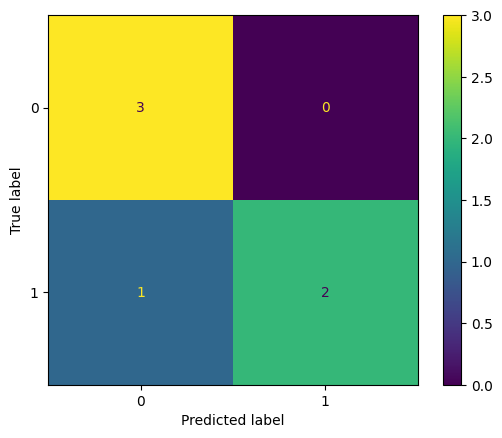

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.50      1.00      0.67         3
    Suceptível       0.00      0.00      0.00         3

      accuracy                           0.50         6
     macro avg       0.25      0.50      0.33         6
  weighted avg       0.25      0.50      0.33         6



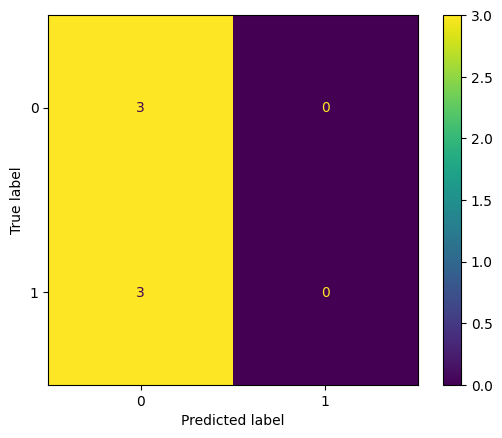

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.00      0.00      0.00         3
    Suceptível       0.40      0.67      0.50         3

      accuracy                           0.33         6
     macro avg       0.20      0.33      0.25         6
  weighted avg       0.20      0.33      0.25         6



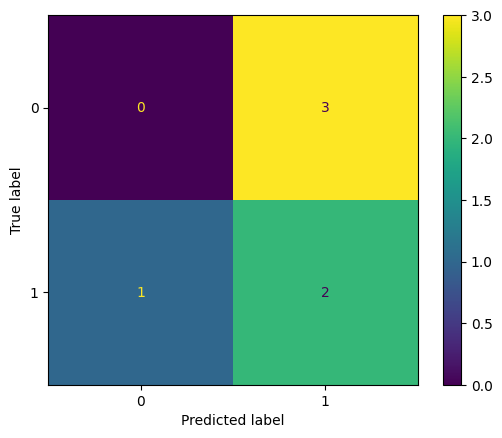

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



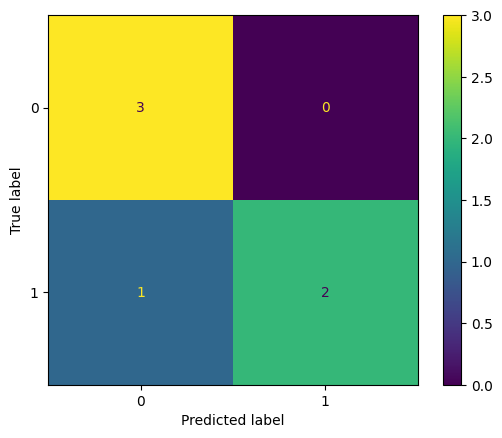

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



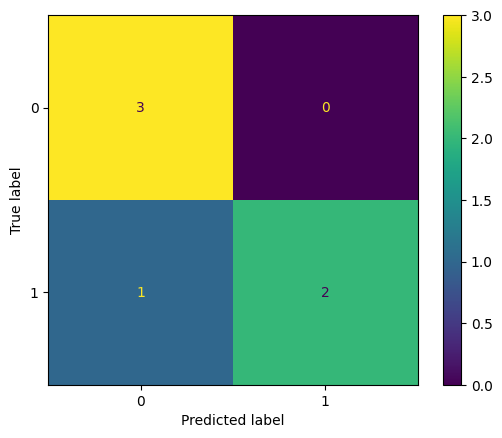

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



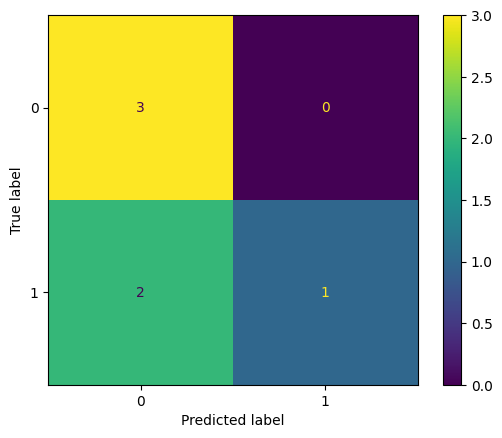

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



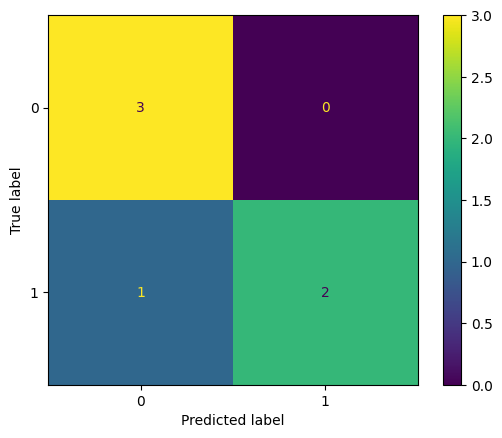

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       0.50      1.00      0.67         2
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.60         5
     macro avg       0.75      0.67      0.58         5
  weighted avg       0.80      0.60      0.57         5



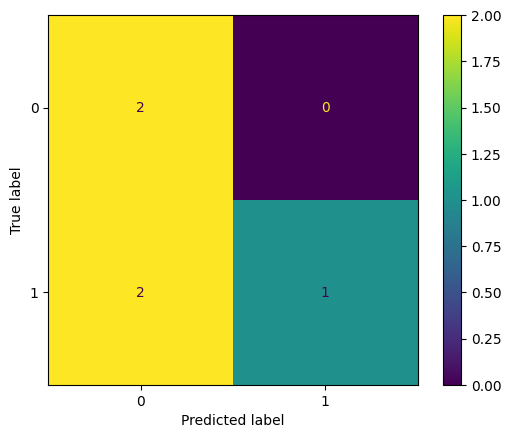

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



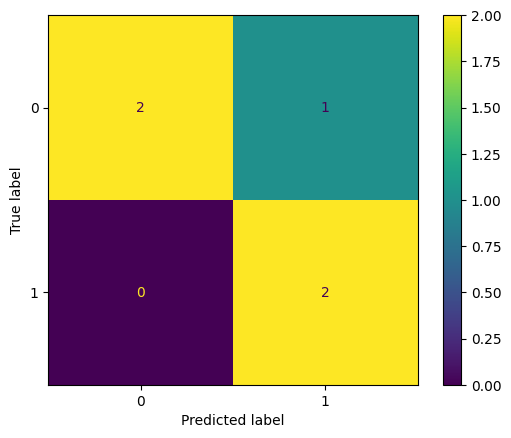

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.50      0.67         2

      accuracy                           0.80         5
     macro avg       0.88      0.75      0.76         5
  weighted avg       0.85      0.80      0.78         5



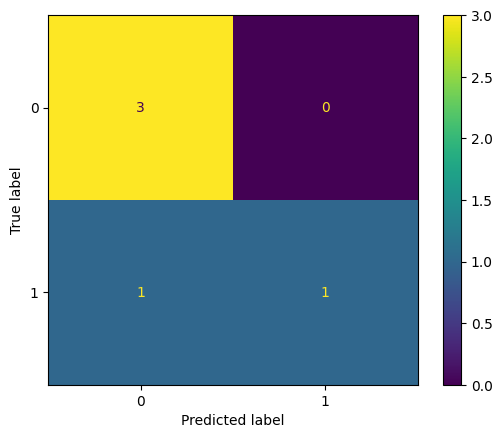

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.64 0.81]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.87 0.55]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.72 0.62]
----------------------------------------------------------------


In [ ]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB()
naive, naive_array_precision = perform_cross_validation(naive, x_train, y_train)

In [ ]:
naive_accuracy = accuracy_score(y_test, naive.predict(x_test))*100
print("Naive",classification_report(y_test, naive.predict(x_test)))
print('Accuracy: ', naive_accuracy)

Naive               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7

Accuracy:  85.71428571428571


##### ***Decision Tree***

{'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'entropy'}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



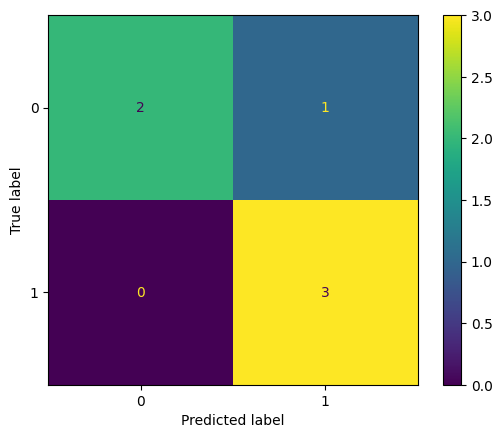

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       1.00      0.33      0.50         3
    Suceptível       0.60      1.00      0.75         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



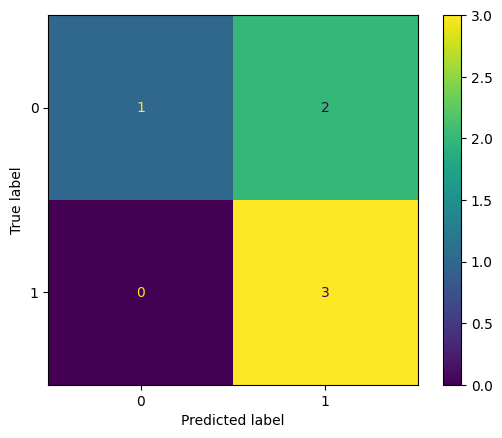

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.33      0.33      0.33         3
    Suceptível       0.33      0.33      0.33         3

      accuracy                           0.33         6
     macro avg       0.33      0.33      0.33         6
  weighted avg       0.33      0.33      0.33         6



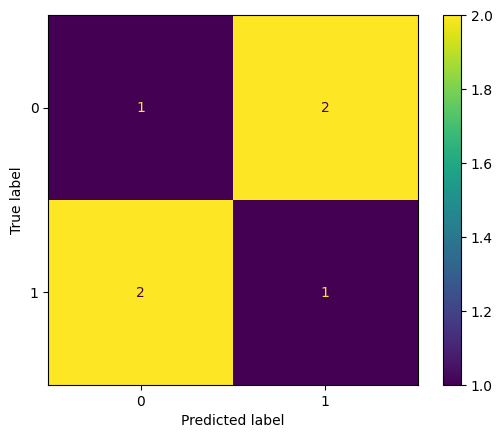

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       1.00      0.33      0.50         3
    Suceptível       0.60      1.00      0.75         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



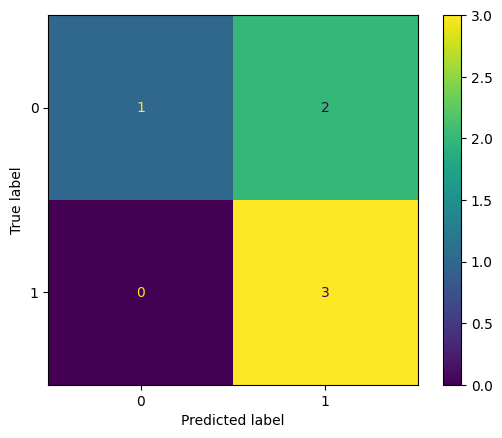

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



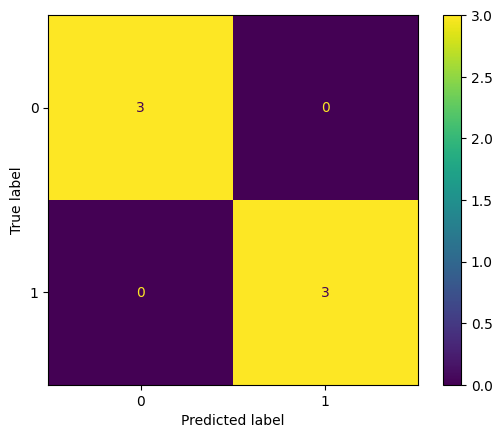

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       0.50      0.33      0.40         3
    Suceptível       0.50      0.67      0.57         3

      accuracy                           0.50         6
     macro avg       0.50      0.50      0.49         6
  weighted avg       0.50      0.50      0.49         6



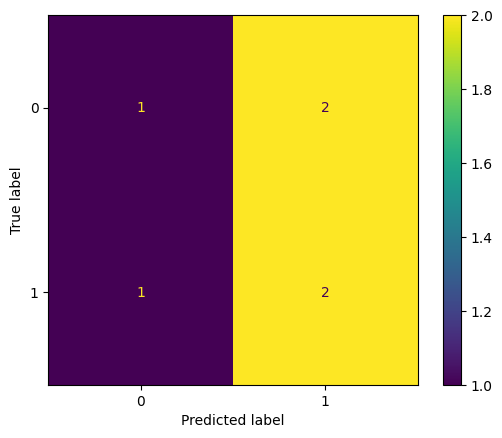

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.00      0.00      0.00         3
    Suceptível       0.50      1.00      0.67         3

      accuracy                           0.50         6
     macro avg       0.25      0.50      0.33         6
  weighted avg       0.25      0.50      0.33         6



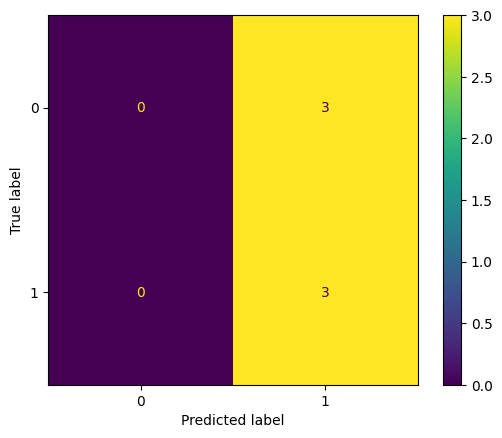

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       0.67      1.00      0.80         2
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



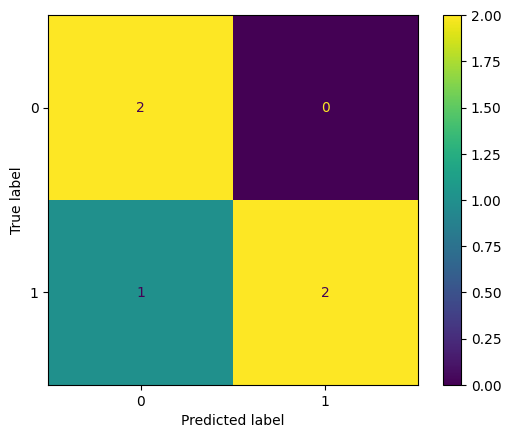

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



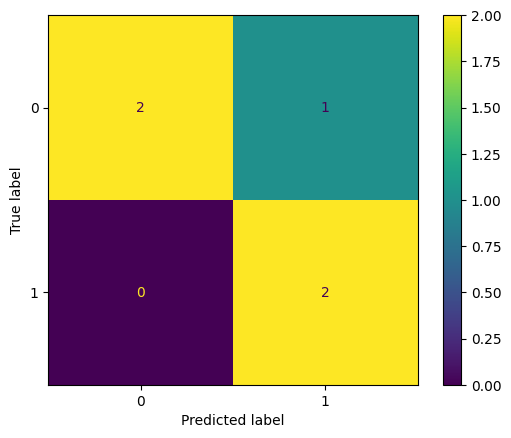

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       0.50      0.67      0.57         3
    Suceptível       0.00      0.00      0.00         2

      accuracy                           0.40         5
     macro avg       0.25      0.33      0.29         5
  weighted avg       0.30      0.40      0.34         5



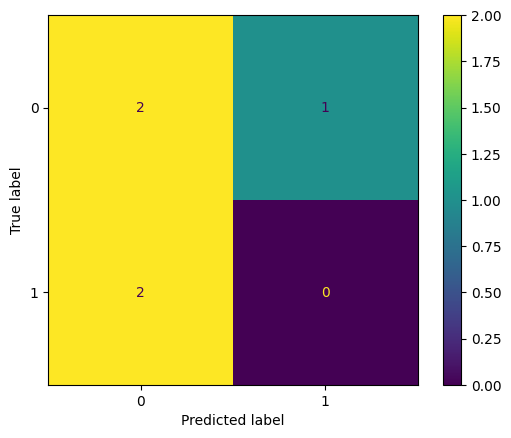

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.7 0.6]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.53 0.77]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.57 0.65]
----------------------------------------------------------------


In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import t

dt_parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter':  ['best', 'random'],
    'max_depth': ["None", 2, 4, 6, 8, 10, 15],
    'max_features': ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]
}

# cria o modelo
dtclf = DecisionTreeClassifier()
dt_tuned_params = tuning_hyperparams(dtclf, dt_parameters, x_train, y_train, iterations=100)
print(dt_tuned_params)

dtclf = DecisionTreeClassifier(criterion=dt_tuned_params.get('criterion'),
                               splitter=dt_tuned_params.get('splitter'),
                               max_depth=dt_tuned_params.get('max_depth'),
                               max_features=dt_tuned_params.get('max_features'),
                               random_state=69)
dtBest, dt_array_precision = perform_cross_validation(dtclf, x_train, y_train)

In [ ]:
dt_accuracy = accuracy_score(y_test, dtBest.predict(x_test))*100
print("Decision Tree",classification_report(y_test, dtBest.predict(x_test)))
print('Accuracy: ', dt_accuracy)

Decision Tree               precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         4
         1.0       0.50      0.67      0.57         3

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7

Accuracy:  57.14285714285714


##### ***Random Forest***

{'n_estimators': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



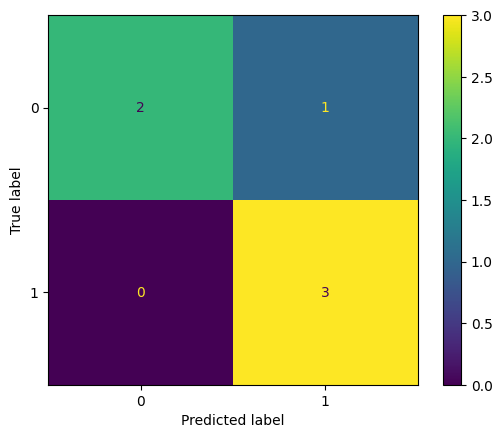

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



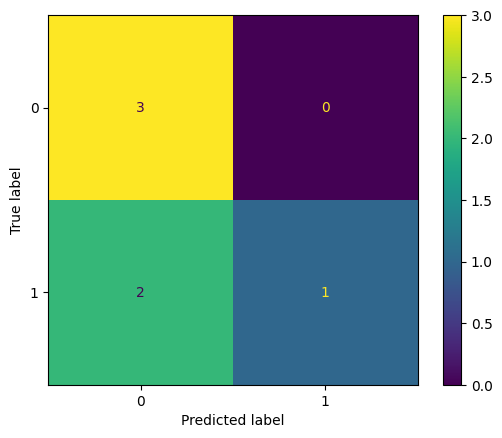

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



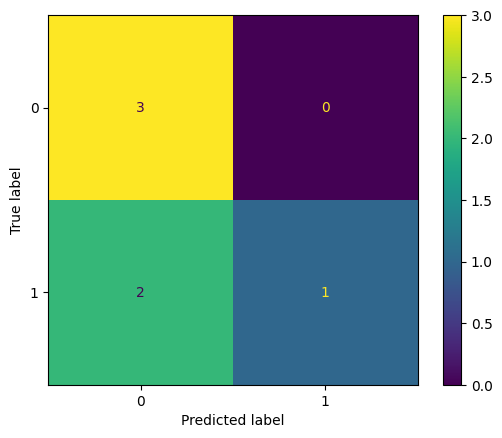

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



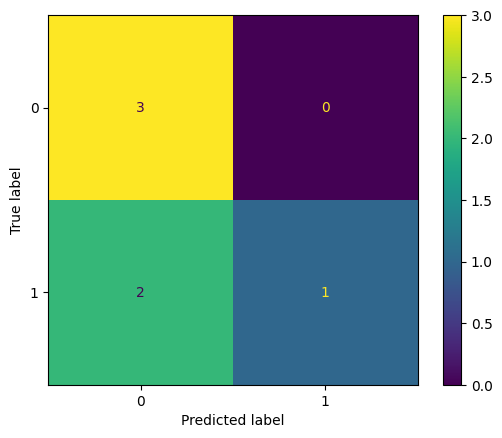

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



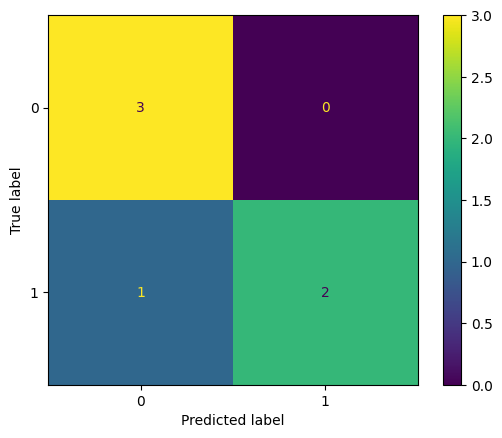

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



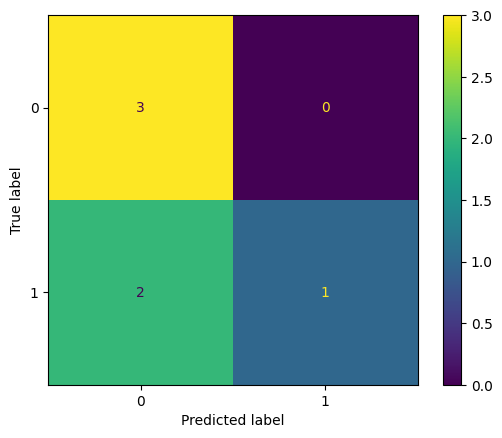

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       1.00      0.33      0.50         3
    Suceptível       0.60      1.00      0.75         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



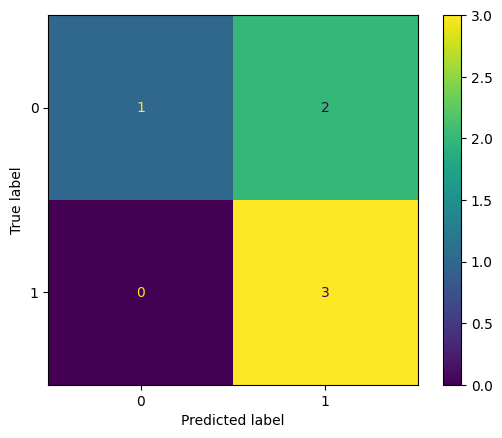

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       0.50      1.00      0.67         2
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.60         5
     macro avg       0.75      0.67      0.58         5
  weighted avg       0.80      0.60      0.57         5



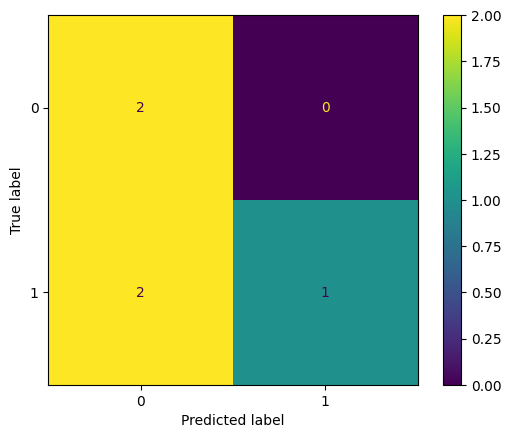

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



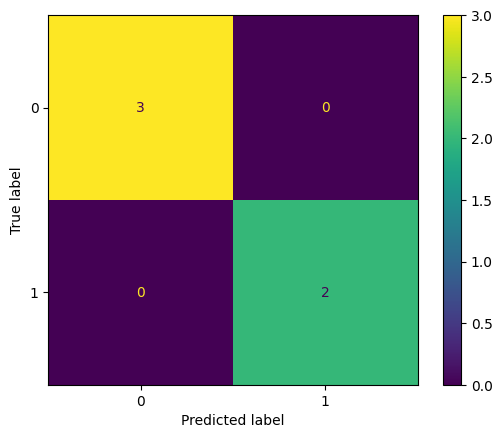

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.50      0.67         2

      accuracy                           0.80         5
     macro avg       0.88      0.75      0.76         5
  weighted avg       0.85      0.80      0.78         5



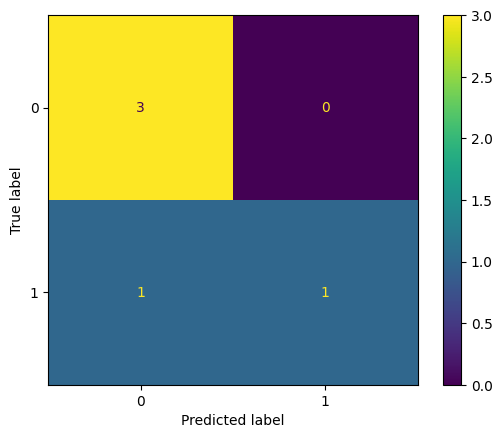

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.74 0.94]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.9  0.58]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.77 0.66]
----------------------------------------------------------------


In [ ]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import RandomizedSearchCV

rfparameters = {
    'criterion'        : ['gini', 'entropy', 'log_loss'],
    'n_estimators'     : [10, 20, 30, 50, 60, 70, 100, 110, 120, 130],
    'max_features'     : ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'max_depth'        : [5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10, 20, 40]
}

rf_clf = RandomForestClassifier()
rf_tuned_params = tuning_hyperparams(rf_clf, rfparameters, x_train, y_train, iterations=100)
print(rf_tuned_params)

random_forest = RandomForestClassifier(n_estimators=rf_tuned_params.get('n_estimators'),
                                       min_samples_leaf=rf_tuned_params.get('min_samples_leaf'),
                                       max_features=rf_tuned_params.get('max_features'),
                                       max_depth=rf_tuned_params.get('max_depth'),
                                       criterion=rf_tuned_params.get('criterion'),
                                       random_state=143)

random_forest, random_forest_array_precision = perform_cross_validation(random_forest, x_train, y_train)

In [ ]:
# accuracy
random_forest_accuracy = accuracy_score(y_test, random_forest.predict(x_test))*100
print("Random Forest",classification_report(y_test, random_forest.predict(x_test)))
print('Accuracy: ', random_forest_accuracy)

Random Forest               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

Accuracy:  71.42857142857143


##### ***XGBoost***

{'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.5}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



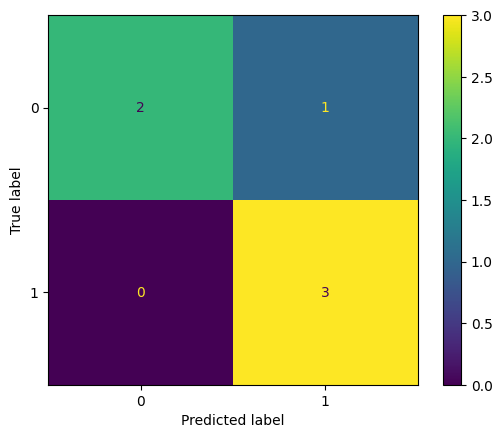

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



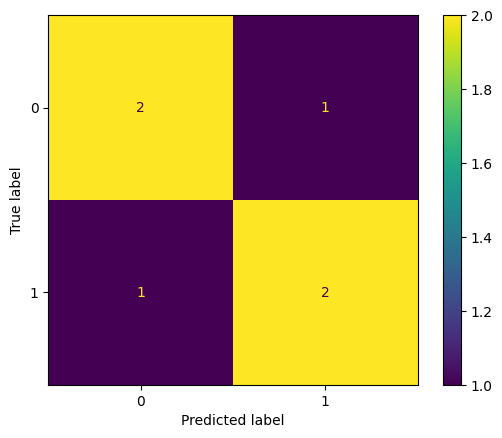

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.60      1.00      0.75         3
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.67         6
     macro avg       0.80      0.67      0.62         6
  weighted avg       0.80      0.67      0.62         6



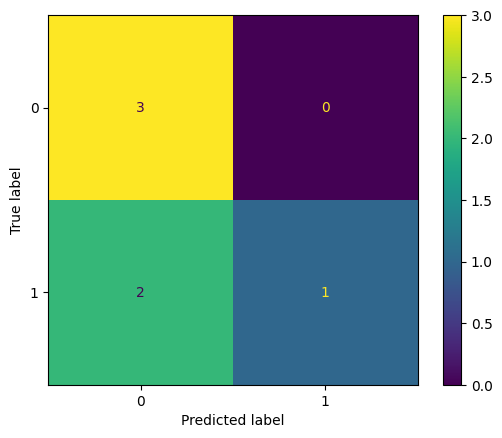

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



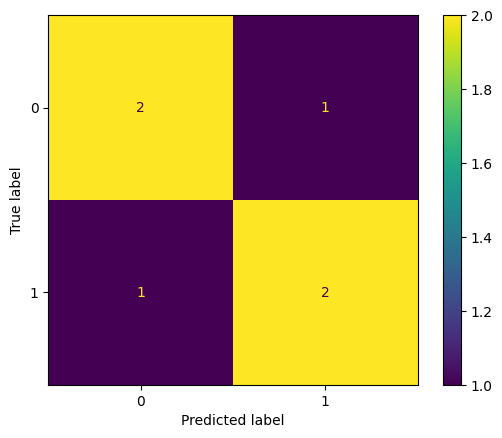

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



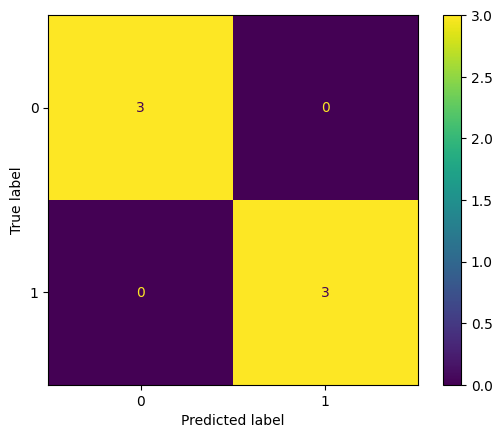

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



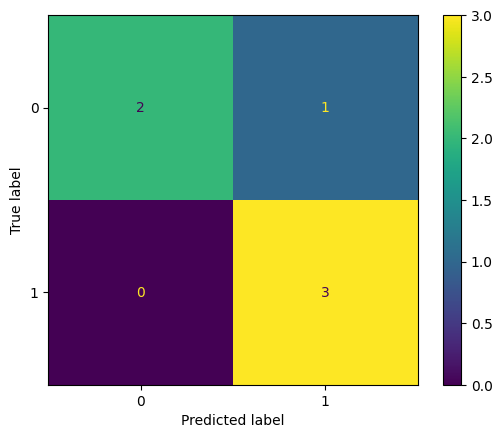

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



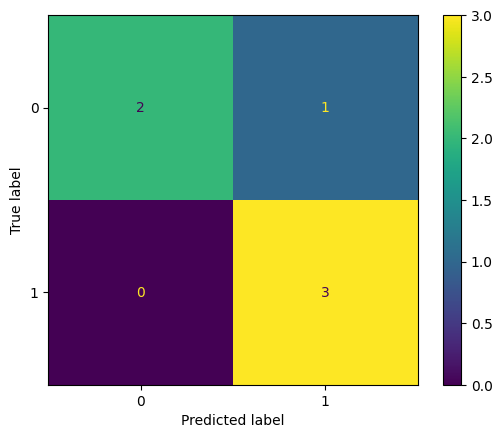

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         2
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



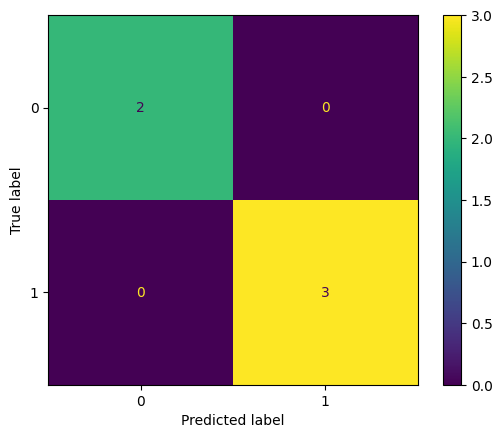

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



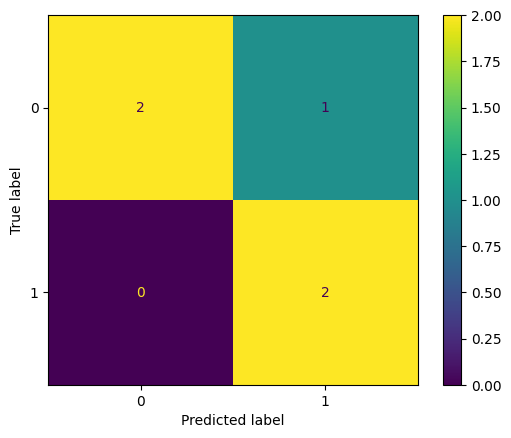

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.50      0.67         2

      accuracy                           0.80         5
     macro avg       0.88      0.75      0.76         5
  weighted avg       0.85      0.80      0.78         5



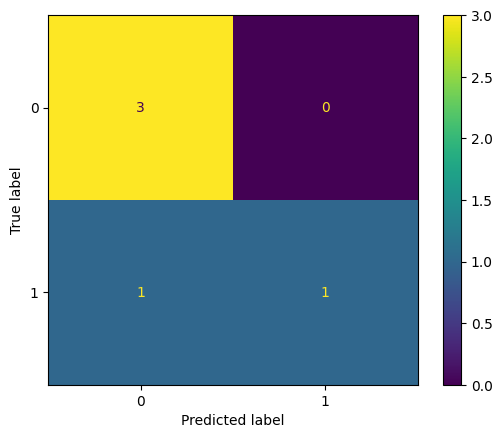

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.87 0.82]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.8  0.82]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.81 0.79]
----------------------------------------------------------------


In [ ]:
from xgboost import XGBClassifier

xgbparameters = {
    'n_estimators':  [100, 200, 300, 400, 500, 600, 700, 800],
    'max_depth':     [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
}

xgb = XGBClassifier()
xgb_tuned_params = tuning_hyperparams(xgb, xgbparameters, x_train, y_train, iterations=100)
print(xgb_tuned_params)

xgbclf = XGBClassifier(n_estimators=xgb_tuned_params.get('n_estimators'),
                       max_depth=xgb_tuned_params.get('max_depth'),
                       learning_rate=xgb_tuned_params.get('learning_rate'),
                       random_state=42)
xgbBest, xgb_array_precision = perform_cross_validation(xgbclf, x_train, y_train)

In [ ]:
print("XGBoost", classification_report(y_test, xgbBest.predict(x_test)))
xgb_acc = accuracy_score(y_test, xgbBest.predict(x_test))*100
print('Accuracy:', xgb_acc)

XGBoost               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

Accuracy: 71.42857142857143


##### ***AdaBoost***

{'n_estimators': 70, 'learning_rate': 1.0} 

FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



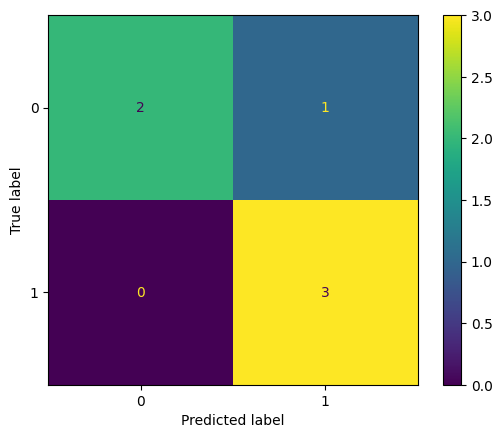

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



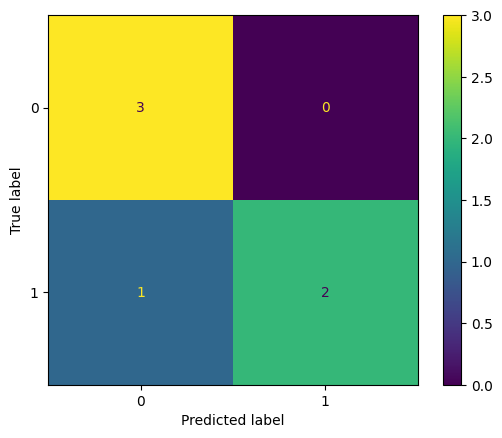

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



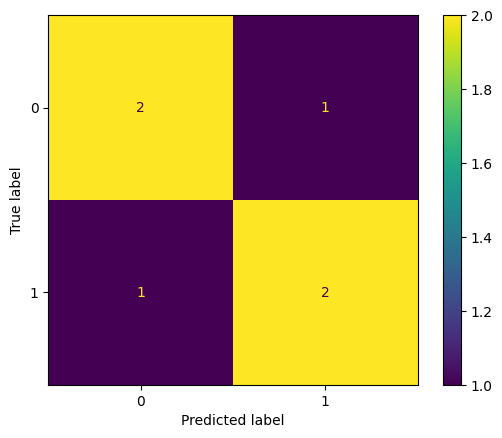

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



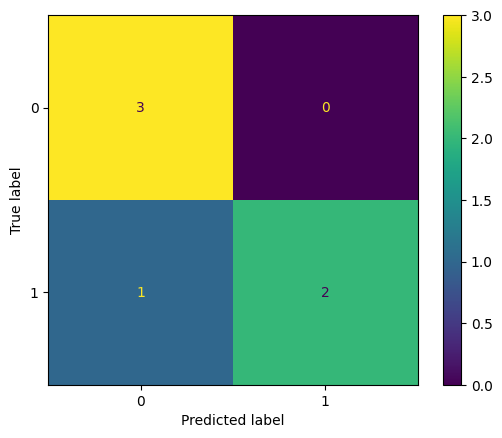

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



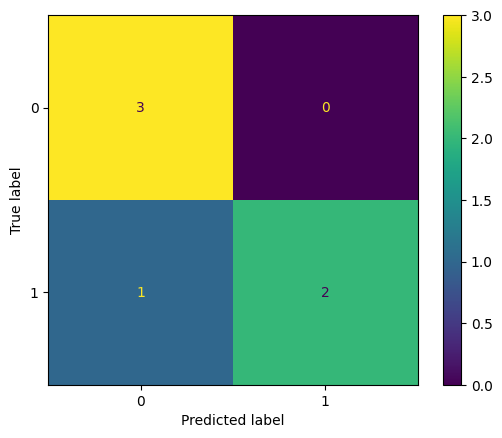

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.75      1.00      0.86         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



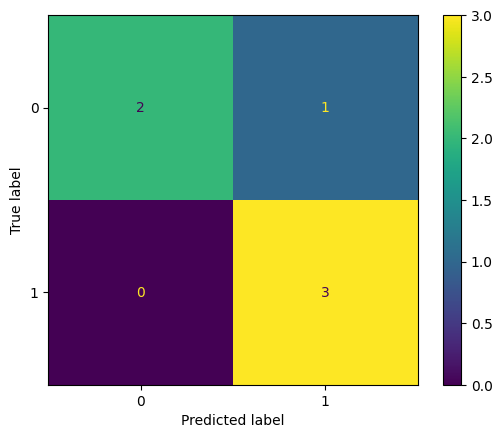

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



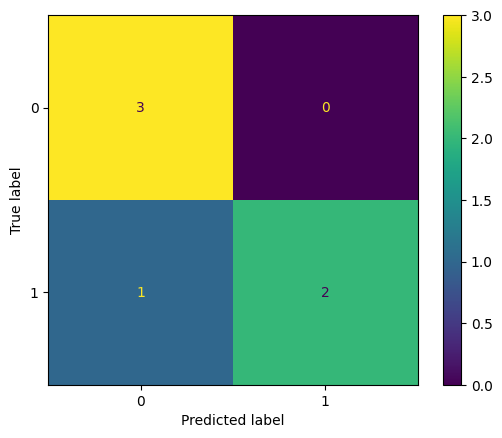

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       0.50      1.00      0.67         2
    Suceptível       1.00      0.33      0.50         3

      accuracy                           0.60         5
     macro avg       0.75      0.67      0.58         5
  weighted avg       0.80      0.60      0.57         5



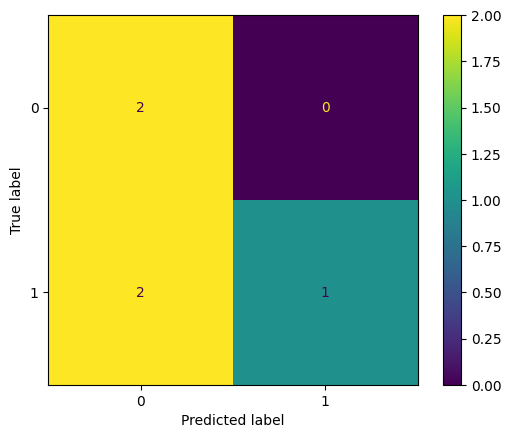

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



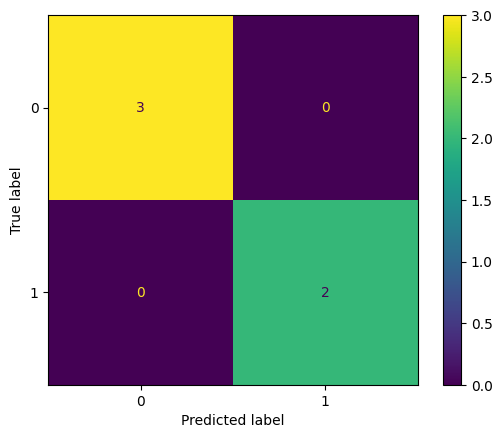

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



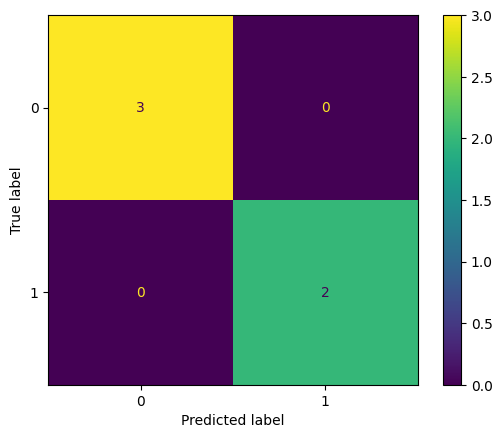

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.82 0.92]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.9  0.77]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.84 0.81]
----------------------------------------------------------------


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_parameters = {
    'n_estimators'  : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
}

adaclf = AdaBoostClassifier()
ada_tuned_params = tuning_hyperparams(adaclf, ada_parameters, x_train, y_train, iterations=100)
print(ada_tuned_params, '\n')

adaclf = AdaBoostClassifier(n_estimators=ada_tuned_params.get('n_estimators'),
                            learning_rate=ada_tuned_params.get('learning_rate'),
                            random_state=42)
adaBest, ada_array_precision = perform_cross_validation(adaclf, x_train, y_train)

In [ ]:
ada_accuracy = accuracy_score(y_test, adaBest.predict(x_test)) * 100
print("AdaBoost", classification_report(y_test, adaBest.predict(x_test)))
print('Accuracy:', ada_accuracy)

AdaBoost               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

Accuracy: 71.42857142857143


##### ***SVM***

{'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



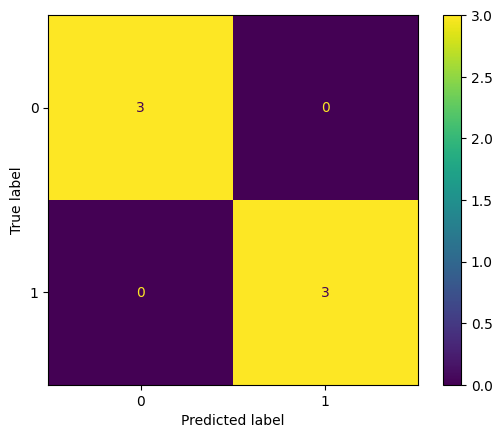

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



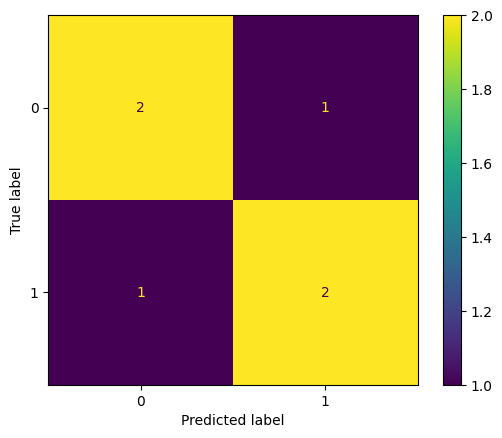

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



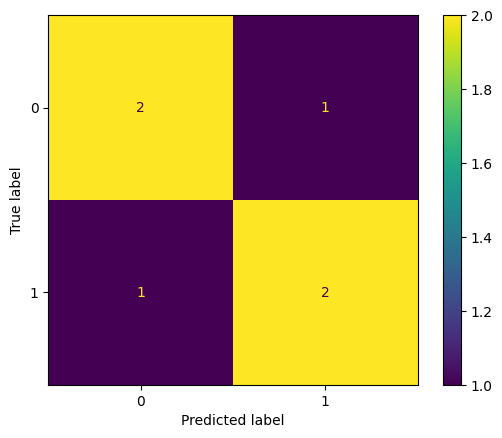

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.50      0.33      0.40         3
    Suceptível       0.50      0.67      0.57         3

      accuracy                           0.50         6
     macro avg       0.50      0.50      0.49         6
  weighted avg       0.50      0.50      0.49         6



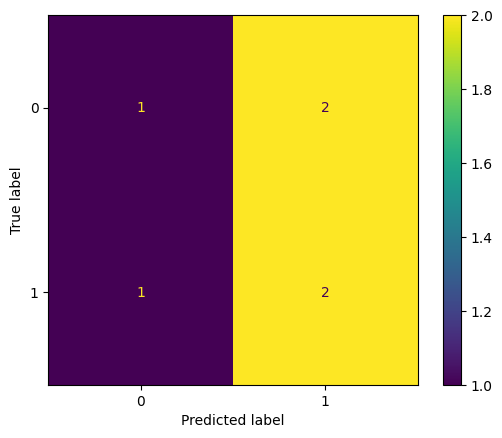

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



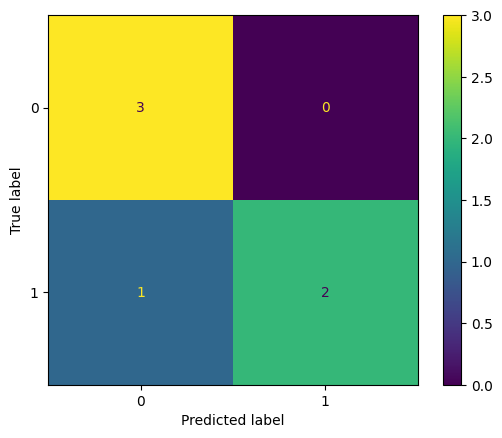

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



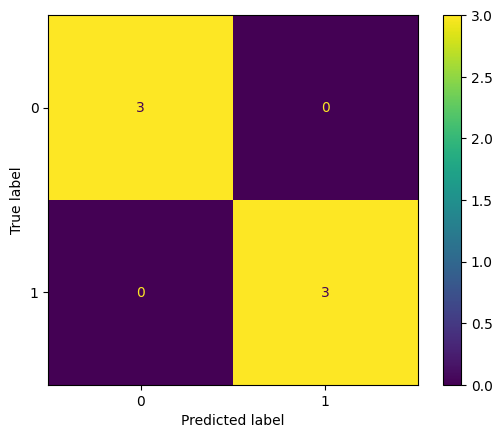

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



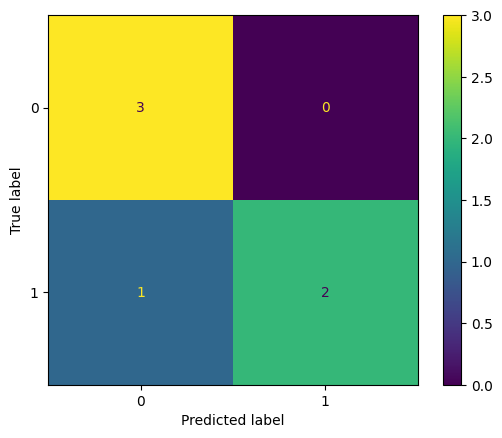

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         2
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



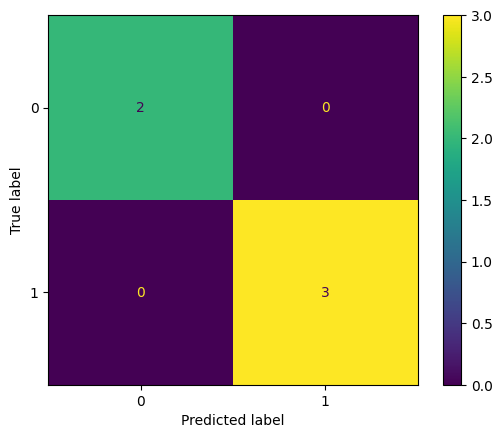

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



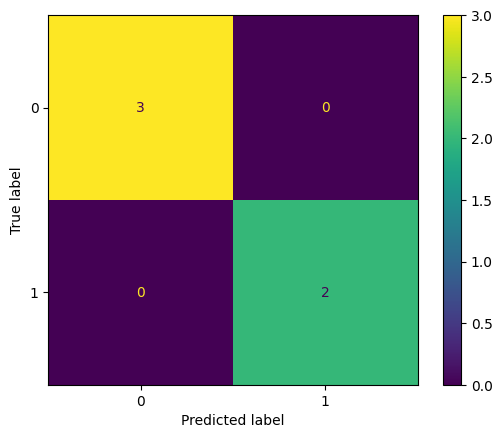

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



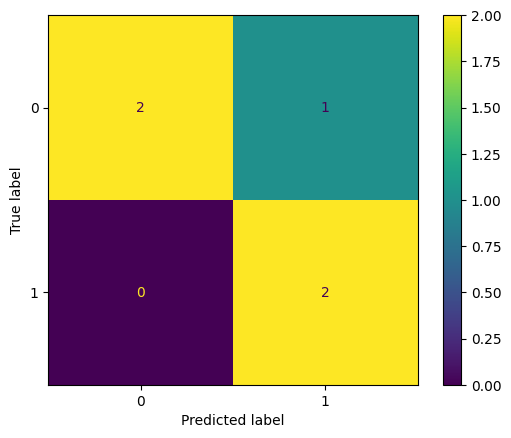

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.83 0.85]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.83 0.83]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.82 0.83]
----------------------------------------------------------------


In [ ]:
from sklearn.svm import SVC

svm_parameters = {
    'C'     : [0.1, 1, 10, 100, 1000],
    'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svmclf = SVC()
svm_tuned_params = tuning_hyperparams(svmclf, svm_parameters, x_train, y_train)#, iterations=100)
print(svm_tuned_params)

svmclf = SVC(C=svm_tuned_params.get('C'),
             gamma=svm_tuned_params.get('gamma'),
             kernel=svm_tuned_params.get('kernel'),
             random_state=42)
svmBest, svmclf_precision = perform_cross_validation(svmclf, x_train, y_train)

In [ ]:
svm_accuracy = accuracy_score(y_test, svmBest.predict(x_test)) * 100
print("SVM", classification_report(y_test, svmBest.predict(x_test)))
print('Accuracy:', svm_accuracy)

SVM               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7

Accuracy: 85.71428571428571


##### ***Logistic Regression***

{'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 4000, 'class_weight': 'balanced', 'C': 10}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



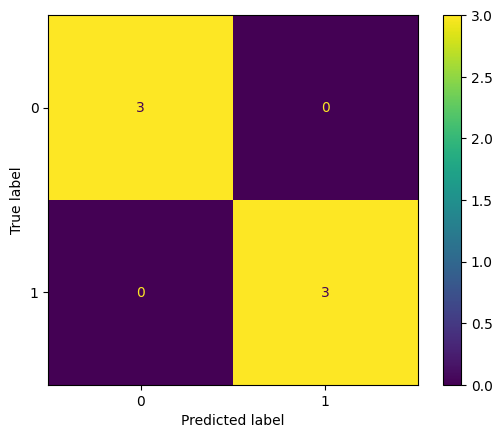

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.50      0.67      0.57         3
    Suceptível       0.50      0.33      0.40         3

      accuracy                           0.50         6
     macro avg       0.50      0.50      0.49         6
  weighted avg       0.50      0.50      0.49         6



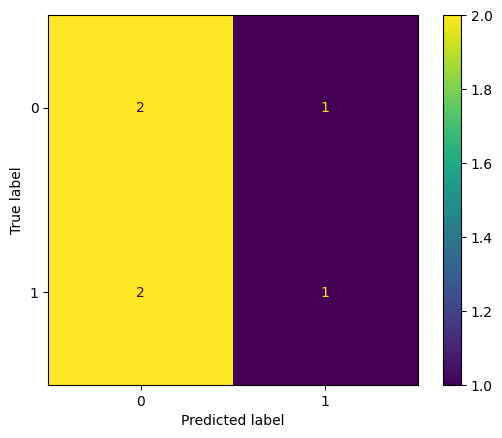

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.50      0.33      0.40         3
    Suceptível       0.50      0.67      0.57         3

      accuracy                           0.50         6
     macro avg       0.50      0.50      0.49         6
  weighted avg       0.50      0.50      0.49         6



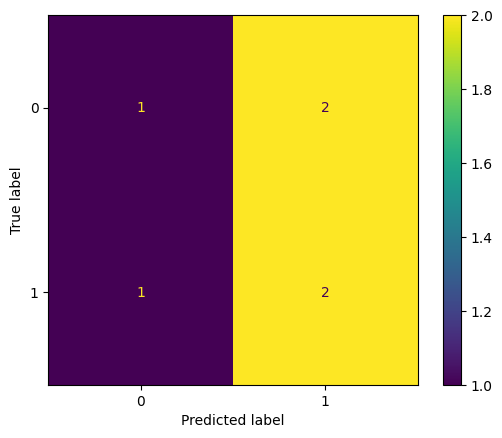

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



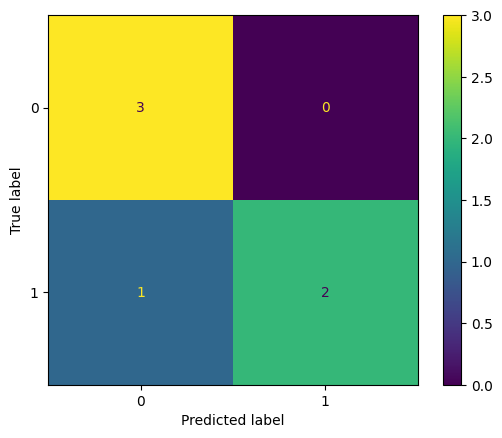

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



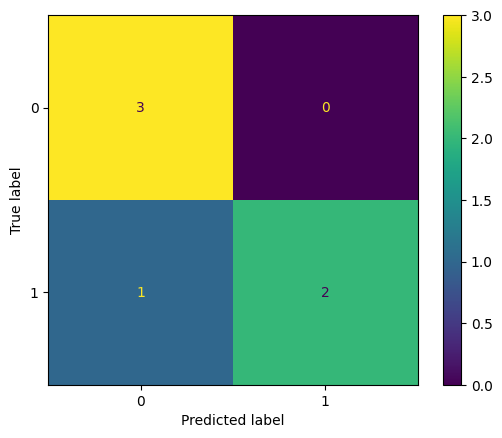

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



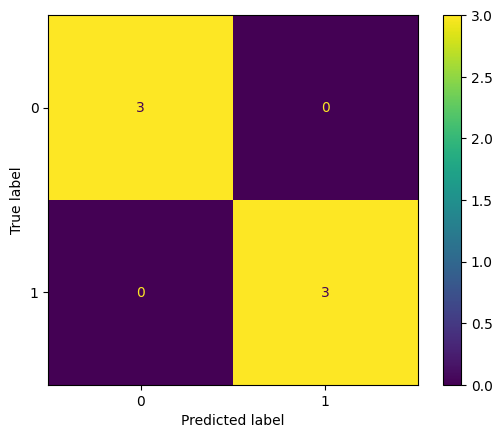

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



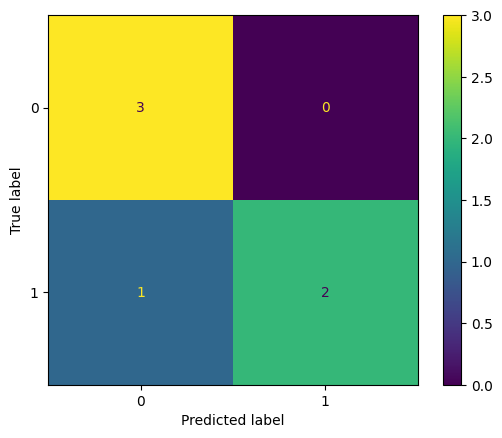

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         2
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



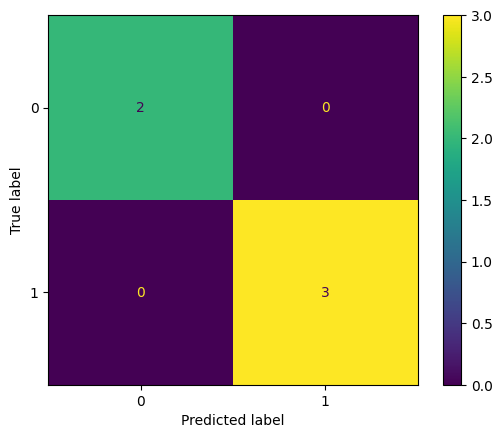

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



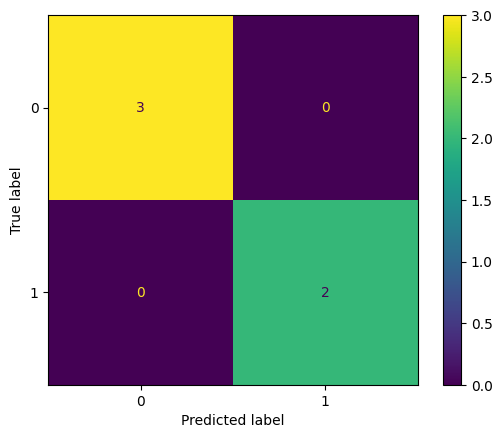

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



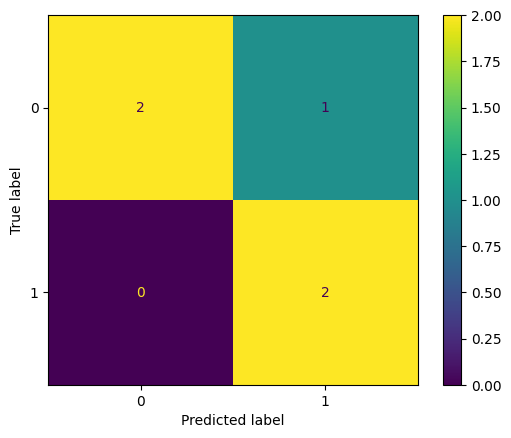

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.82 0.87]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.87 0.8 ]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.83 0.82]
----------------------------------------------------------------


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_parameters = {
    'solver'      : ['lbfgs', 'sag', 'saga', 'newton-cg', 'liblinear'],
    'penalty'     : ['None', 'l1', 'l2', 'elasticnet'], # regularization
    'C'           : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter'    : [4000],
    'class_weight': ['None', 'balanced'],
    'multi_class' : ['auto', 'ovr', 'multinomial']
}

logregclf = LogisticRegression()#random_state=0)
logreg_tuned_params = tuning_hyperparams(logregclf, logreg_parameters, x_train, y_train, iterations=100)
print(logreg_tuned_params)
logregclf = LogisticRegression(solver=logreg_tuned_params.get('solver'),
                               penalty=logreg_tuned_params.get('penalty'),
                               C=logreg_tuned_params.get('C'),
                               max_iter=logreg_tuned_params.get('max_iter'),
                               random_state=42)
logregBest, logreg_precision = perform_cross_validation(logregclf, x_train, y_train)

In [ ]:
logreg_accuracy = accuracy_score(y_test, logregBest.predict(x_test)) * 100
print("Logistic Regression", classification_report(y_test, logregBest.predict(x_test)))
print('Accuracy:', logreg_accuracy)

Logistic Regression               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7

Accuracy: 85.71428571428571


##### ***Neural Network***

{'solver': 'adam', 'max_iter': 6000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (5,), 'batch_size': 8, 'alpha': 0.01, 'activation': 'tanh'}
FOLD: 1
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



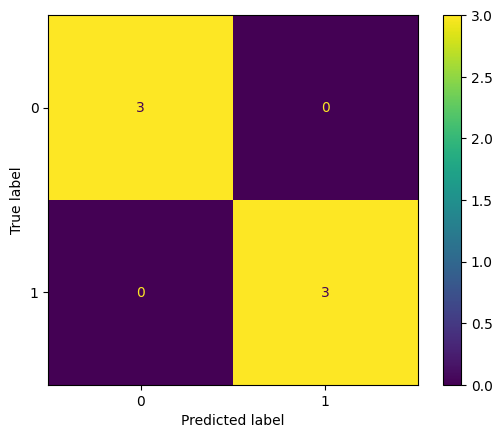

---------------------------------------------------------
FOLD: 2
                precision    recall  f1-score   support

Não suceptível       0.67      0.67      0.67         3
    Suceptível       0.67      0.67      0.67         3

      accuracy                           0.67         6
     macro avg       0.67      0.67      0.67         6
  weighted avg       0.67      0.67      0.67         6



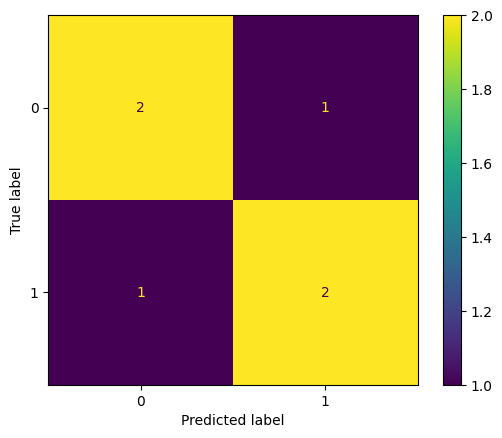

---------------------------------------------------------
FOLD: 3
                precision    recall  f1-score   support

Não suceptível       0.50      0.33      0.40         3
    Suceptível       0.50      0.67      0.57         3

      accuracy                           0.50         6
     macro avg       0.50      0.50      0.49         6
  weighted avg       0.50      0.50      0.49         6



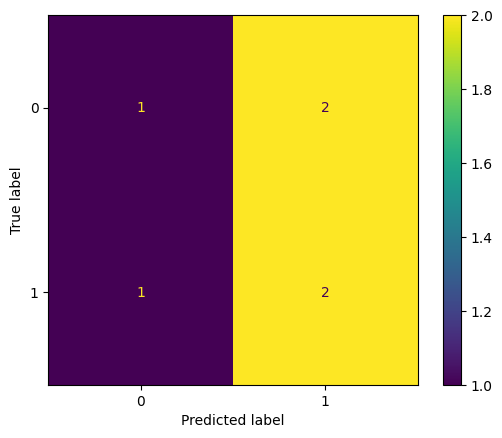

---------------------------------------------------------
FOLD: 4
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



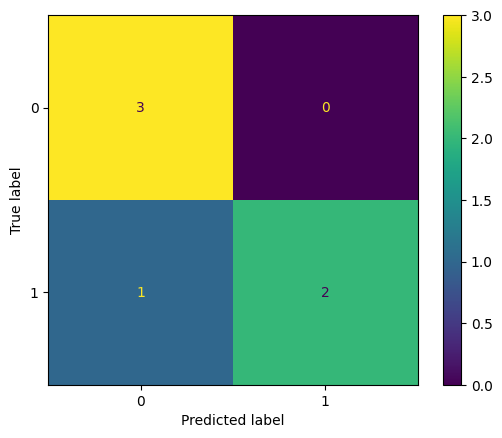

---------------------------------------------------------
FOLD: 5
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



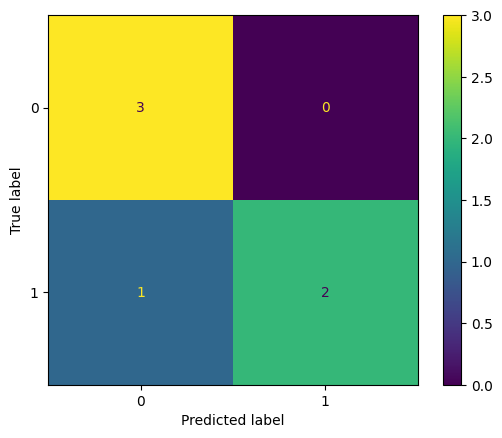

---------------------------------------------------------
FOLD: 6
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



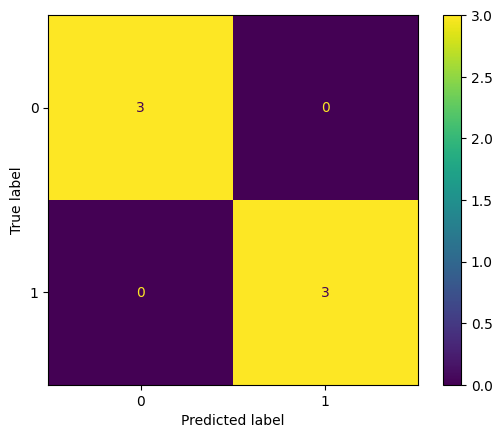

---------------------------------------------------------
FOLD: 7
                precision    recall  f1-score   support

Não suceptível       0.75      1.00      0.86         3
    Suceptível       1.00      0.67      0.80         3

      accuracy                           0.83         6
     macro avg       0.88      0.83      0.83         6
  weighted avg       0.88      0.83      0.83         6



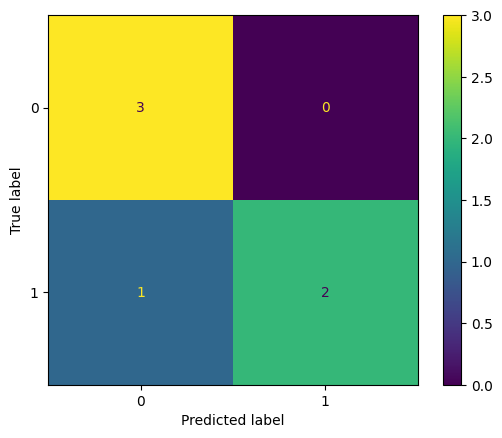

---------------------------------------------------------
FOLD: 8
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         2
    Suceptível       1.00      1.00      1.00         3

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



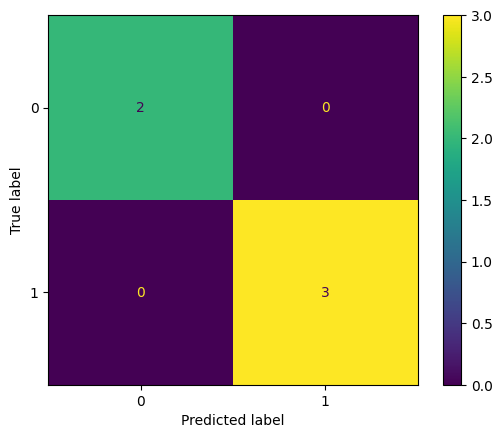

---------------------------------------------------------
FOLD: 9
                precision    recall  f1-score   support

Não suceptível       1.00      1.00      1.00         3
    Suceptível       1.00      1.00      1.00         2

      accuracy                           1.00         5
     macro avg       1.00      1.00      1.00         5
  weighted avg       1.00      1.00      1.00         5



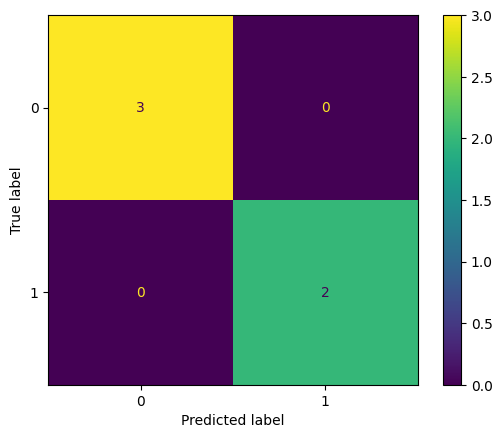

---------------------------------------------------------
FOLD: 10
                precision    recall  f1-score   support

Não suceptível       1.00      0.67      0.80         3
    Suceptível       0.67      1.00      0.80         2

      accuracy                           0.80         5
     macro avg       0.83      0.83      0.80         5
  weighted avg       0.87      0.80      0.80         5



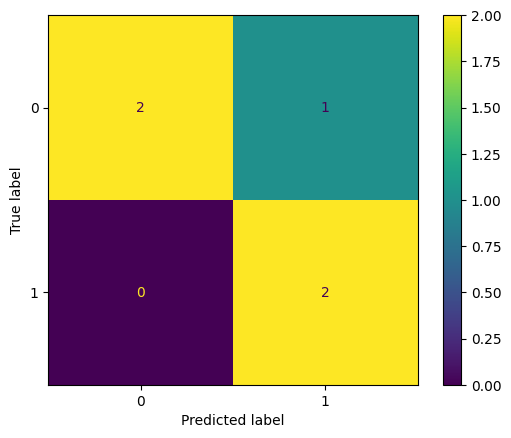

---------------------------------------------------------
Precisão média na validação das classes Inferior e Superior: [0.84 0.88]
----------------------------------------------------------------
Recall médio na validação das classes Inferior e Superior: [0.87 0.83]
----------------------------------------------------------------
F1 score médio na validação das classes Inferior e Superior: [0.84 0.84]
----------------------------------------------------------------


In [ ]:
from sklearn.neural_network import MLPClassifier

nn_parameters = {
    #'hidden_layer_sizes': [(50,50,50), (50,100,50), (100, 100, 100)],
    #'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),
    #                      (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)],
    'hidden_layer_sizes': [(5,),(5,5), (10,), (10,10), (15,), (15,15), (20,), (20,20)],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'batch_size': [8, 16, 32],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [6000],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp = MLPClassifier()
nn_tuned_params = tuning_hyperparams(mlp, nn_parameters, x_train, y_train);
print(nn_tuned_params)

mlp = MLPClassifier(hidden_layer_sizes=nn_tuned_params.get('hidden_layer_sizes'),
                    alpha=nn_tuned_params.get('alpha'),
                    solver=nn_tuned_params.get('solver'),
                    learning_rate=nn_tuned_params.get('learning_rate'),
                    batch_size=nn_tuned_params.get('batch_size'),
                    random_state=42,
                    activation=nn_tuned_params.get('activation'),
                    max_iter=nn_tuned_params.get('max_iter'))

mlpBest, mlp_array_precision = perform_cross_validation(mlp, x_train, y_train)

In [ ]:
#mlp_pred = mlpBest.predict(x_test)
#mlp_accuracy = accuracy_score(y_test, mlpBest.predict(x_test))*100
mlp_accuracy = accuracy_score(y_test, mlpBest.predict(x_test))*100
print("MLP", classification_report(y_test, mlpBest.predict(x_test)))
print('Accuracy:', mlp_accuracy)
#pred = mlpBest.predict(x_test)

MLP               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7

Accuracy: 85.71428571428571


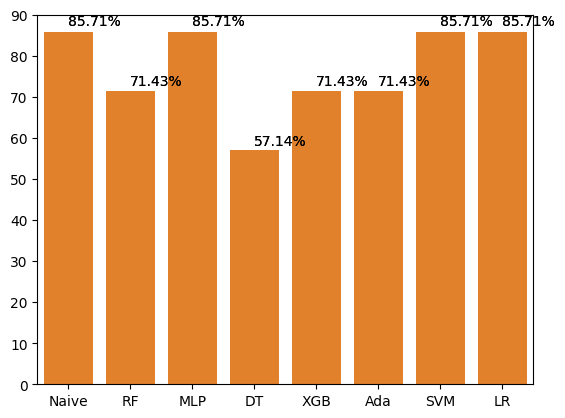

In [ ]:
# plot precision of each method
import seaborn as sns

model_list = ['Naive', 'RF', 'MLP', 'DT', 'XGB', 'Ada', 'SVM', 'LR']
accuracy_list = [naive_accuracy, random_forest_accuracy, mlp_accuracy, dt_accuracy,
                 xgb_acc, ada_accuracy, svm_accuracy, logreg_accuracy]
plt.bar(model_list, accuracy_list)
ax = sns.barplot(x=model_list, y=accuracy_list)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xf, yf = i.get_xy()
    ax.annotate(f'{round(height,2)}%', (xf + width/2, yf + height*1.02))
plt.show()

#### **Inference**
Inference with dataset of 5000 instances.

In [ ]:
#inference_data = pd.read_csv('/content/drive/MyDrive/covid_colab/MammalPredictionData231220_wildCategory.csv')
inference_data = pd.read_csv('./MammalPredictionData231220_wildCategory.csv')
inference_data

,Species,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,male_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,infantMortalityRate_per_year,mortalityRateDoublingTime_y,metabolicRate_W,temperature_K,diet_breadth,development_d,mass_specific_production,log_litterclutch_size_n,log_inter_litterbirth_interval_y,log_birthhatching_weight_g,log_weaning_weight_g,log_adult_body_mass_g,log_female_body_mass_g,log_male_body_mass_g,tnc_ecoregion_breadth,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X24.1_TeatNumber,X6.2_TrophicLevel,X13.3_WeaningHeadBodyLen_mm,X26.2_GR_MaxLat_dd,X26.3_GR_MinLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X26.6_GR_MinLong_dd,X26.7_GR_MidRangeLong_dd,X27.4_HuPopDen_Change,X28.1_Precip_Mean_mm,X28.2_Temp_Mean_01degC,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_DispersalAge_d,log_HomeRange_km2,log_HomeRange_Indiv_km2,log_PopulationDensity_n.km2,log_PopulationGrpSize,log_HuPopDen_Min_n.km2,log_HuPopDen_Mean_n.km2,log_HuPopDen_5p_n.km2,log_NeonateHeadBodyLen_mm,log_WOS_hits,Afrosoricida,Artiodactyla,Carnivora,Cetacea,Chiroptera,Cingulata,Dasyuromorphia,Didelphimorphia,Diprotodontia,Erinaceomorpha,Lagomorpha,Macroscelidea,Monotremata,Perissodactyla,Pholidota,Primates,Proboscidea,Rodentia,Sirenia,Soricomorpha,Tubulidentata,traits_wild
0,Tachyglossus aculeatus,1,0,1,1,0,552.425000,548.000000,185.040000,0.580000,49.500000,37.500000,NaN,NaN,2.327,303.85,0.1,19.860000,0.000069,0.000000,1.010916,-0.982163,6.235224,8.061329,7.408325,8.140338,16.000000,15.865353,NaN,17.720000,1.0,NaN,3.0,NaN,-0.890000,-43.640000,-22.260000,153.630000,113.140000,133.390000,0.04,44.830000,209.860000,476.820000,1350.040000,NaN,-0.820981,-0.478036,2.182700,NaN,1.431572,1.261298,-0.166440,2.572396,6.001415,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,Zaglossus attenboroughi,1,0,1,0,0,537.683601,655.289140,144.499628,1.167924,6.127295,46.696643,NaN,NaN,NaN,NaN,0.1,48.776936,0.296117,0.242704,-0.187245,4.328931,6.731150,8.006368,7.296897,7.382646,1.000000,2.731755,NaN,108.781076,NaN,NaN,NaN,NaN,-2.450000,-2.590000,-2.520000,140.720000,140.350000,140.530000,0.14,195.000000,302.500000,1702.500000,1834.500000,NaN,-1.814608,-2.741199,4.447071,NaN,2.079442,2.079442,2.079442,3.978337,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,Zaglossus bartoni,1,0,1,0,0,931.955265,571.227395,152.000000,1.000000,31.000000,67.500000,NaN,NaN,NaN,NaN,0.1,10.000000,-0.027856,0.000000,0.000000,2.487986,5.991465,9.099600,9.207587,8.889625,5.000000,12.068475,NaN,20.781767,NaN,NaN,NaN,NaN,-3.540000,-9.900000,-6.720000,149.380000,136.480000,142.930000,0.14,277.690000,180.290000,1679.270000,1694.360000,NaN,-0.508052,-2.689357,2.767577,NaN,0.000000,2.489894,0.693147,4.041853,1.386294,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,Zaglossus bruijni,1,0,1,0,0,1496.215666,414.475655,152.000000,1.643851,31.000000,67.500000,NaN,NaN,6.493,303.95,0.1,10.000000,0.160647,0.000000,0.229856,2.334527,5.991465,9.210340,8.925861,9.001246,11.737236,10.397196,NaN,10.000000,1.0,NaN,3.0,NaN,-0.007690,-4.140000,-2.070000,136.380000,130.200000,133.290000,0.12,211.510000,220.200000,1735.900000,1953.000000,NaN,1.202026,-2.659640,0.470004,0.0,0.693147,2.314514,0.693147,4.141400,1.098612,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,Ornithorhynchus anatinus,1,0,1,1,1,645.230000,548.000000,113.485000,1.100000,17.000000,41.918000,NaN,NaN,1.931,307.15,0.2,14.740000,-0.007373,0.693147,-0.000685,0.919059,5.707758,7.110696,7.340344,7.443036,11.000000,13.711968,NaN,12.480000,1.0,NaN,3.0,NaN,-16.290000,-43.640000,-29.960000,153.630000,136.530000,145.080000,0.04,76.730000,156.530000,781.200000,1206.890000,NaN,-2.659260,-2.659260,3.083470,NaN,-0.214976,3.213260,0.000000,3.940833,5.981414,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# select the same columns(headers) as training dataset
headers = x_train.columns
inference_data = inference_data.loc[:, headers]
inference_data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha
0,1,0,1,1,0,552.425000,185.040000,0.580000,49.500000,37.500000,19.860000,0.000000,-0.982163,6.235224,8.140338,15.865353,NaN,17.720000,1.0,3.0,-0.890000,-22.260000,153.630000,0.04,476.820000,1350.040000,-0.820981,2.182700,2.572396,0,0,0,0,0,0,0,0
1,1,0,1,0,0,537.683601,144.499628,1.167924,6.127295,46.696643,48.776936,0.242704,4.328931,6.731150,7.382646,2.731755,NaN,108.781076,NaN,NaN,-2.450000,-2.520000,140.720000,0.14,1702.500000,1834.500000,-1.814608,4.447071,3.978337,0,0,0,0,0,0,0,0
2,1,0,1,0,0,931.955265,152.000000,1.000000,31.000000,67.500000,10.000000,0.000000,2.487986,5.991465,8.889625,12.068475,NaN,20.781767,NaN,NaN,-3.540000,-6.720000,149.380000,0.14,1679.270000,1694.360000,-0.508052,2.767577,4.041853,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1496.215666,152.000000,1.643851,31.000000,67.500000,10.000000,0.000000,2.334527,5.991465,9.001246,10.397196,NaN,10.000000,1.0,3.0,-0.007690,-2.070000,136.380000,0.12,1735.900000,1953.000000,1.202026,0.470004,4.141400,0,0,0,0,0,0,0,0
4,1,0,1,1,1,645.230000,113.485000,1.100000,17.000000,41.918000,14.740000,0.693147,0.919059,5.707758,7.443036,13.711968,NaN,12.480000,1.0,3.0,-16.290000,-29.960000,153.630000,0.04,781.200000,1206.890000,-2.659260,3.083470,3.940833,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0,1,1,1,1,3652.000000,352.235000,0.534471,28.000000,300.000000,308.164500,0.000000,8.853665,10.494712,13.044675,12.566438,NaN,304.160000,NaN,3.0,13.138568,6.215936,35.634297,NaN,878.760269,1317.756432,0.385628,-0.428205,6.926658,0,0,0,0,0,0,0,0
5396,0,1,0,0,1,1826.250000,365.280000,0.666667,30.000000,255.654500,299.185880,0.000000,8.824678,9.316429,11.944708,13.424894,NaN,314.250000,1.0,3.0,11.273115,6.215936,35.634297,NaN,878.810023,1332.555855,0.142875,-0.383876,6.544058,0,0,0,0,0,0,0,0
5397,0,1,0,0,1,3144.583000,290.233398,0.635000,23.229167,210.086000,319.474000,0.000000,9.358183,9.211408,11.663389,10.170752,NaN,319.370000,4.0,3.0,13.880770,6.215936,35.634297,NaN,906.467494,1334.662551,1.506446,-0.471540,6.817787,0,0,0,0,0,0,0,0
5398,0,1,0,0,1,916.780540,317.834000,0.635000,16.000000,175.000000,329.625560,0.000000,8.974618,10.010136,10.769212,12.837693,NaN,326.890000,NaN,3.0,13.738216,6.215936,35.634297,NaN,874.904756,1318.684199,-0.449086,-0.116728,6.370160,0,0,0,0,0,0,0,0


In [ ]:
# Remove outliers
inference_data = remove_out(inference_data)
# Normalization (MinMaxScaler)
scaler = MinMaxScaler()
inference_data_scaled = scaler.fit_transform(inference_data)
inference_data = pd.DataFrame(inference_data_scaled, columns=inference_data.columns)
# Impute missing values
imputer = KNNImputer(n_neighbors=5)
inference_data = pd.DataFrame(imputer.fit_transform(inference_data),columns = inference_data.columns)
inference_data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha
0,0.0,0.0,1.0,1.0,0.0,0.290383,0.461459,0.106977,0.475782,0.100617,0.041314,0.165312,0.253741,0.566935,0.587255,0.755821,0.210792,0.027921,0.000000,1.0,0.393411,0.269949,0.925130,0.365854,0.254681,0.558142,0.649993,0.271763,0.130234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.282884,0.359287,0.243703,0.266958,0.127515,0.145301,0.248258,0.622607,0.611584,0.525661,0.351390,0.416113,0.357268,0.009756,0.0,0.381375,0.433862,0.888476,0.609756,0.915820,0.840934,0.550120,0.471360,0.458671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.483456,0.378190,0.204651,0.875676,0.188362,0.005857,0.165312,0.494750,0.544989,0.648166,0.529364,0.282151,0.038995,0.008537,0.4,0.372965,0.398987,0.913063,0.609756,0.903290,0.759131,0.681447,0.323318,0.473509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.770504,0.378190,0.354384,0.875676,0.188362,0.005857,0.165312,0.484092,0.544989,0.657240,0.429684,0.286981,0.000000,0.000000,1.0,0.400218,0.437599,0.876153,0.560976,0.933836,0.910106,0.853333,0.120793,0.496763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.337595,0.281122,0.227907,0.533049,0.113539,0.022902,0.402199,0.385785,0.519446,0.530570,0.627387,0.265698,0.008970,0.000000,1.0,0.274593,0.206012,0.925130,0.365854,0.418865,0.474582,0.465221,0.351163,0.449909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.0,0.0,1.0,1.0,1.0,0.857696,0.882833,0.096389,0.802256,0.868383,0.861546,0.165312,0.936860,0.950421,0.985937,0.559064,0.086906,0.593499,0.297561,1.0,0.501648,0.506402,0.590115,0.458537,0.471490,0.539297,0.771274,0.041619,0.731830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5396,0.0,0.0,0.0,0.0,1.0,0.938397,0.915710,0.127132,0.851202,0.738680,0.856467,0.165312,0.934846,0.844339,0.896518,0.610265,0.303396,0.882380,0.000000,1.0,0.487255,0.506402,0.590115,0.517073,0.471517,0.547936,0.746874,0.045527,0.829307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5397,0.0,0.0,0.0,0.0,1.0,0.474208,0.726573,0.119767,0.685498,0.605400,0.872027,0.165312,0.971899,0.834884,0.873650,0.416179,0.307321,0.882437,0.073171,1.0,0.507374,0.506402,0.590115,0.551220,0.486435,0.549166,0.883932,0.037799,0.799116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5398,0.0,0.0,0.0,0.0,1.0,0.475737,0.796134,0.119767,0.508576,0.502780,0.859383,0.165312,0.945260,0.906794,0.800960,0.575243,0.307321,0.877054,0.141463,1.0,0.506274,0.506402,0.590115,0.531707,0.469410,0.539839,0.687374,0.069075,0.816879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# run the model on these 5000 instances
pred = mlpBest.predict(inference_data)
pred, print(len(pred))

5400


(array([1., 1., 0., ..., 0., 0., 0.]), None)

In [ ]:
# creates the label column with prediction values
inference_data['classe'] = pred
inference_data

,ForStrat_terrestrial,ForStrat_aquatic,Activity.Nocturnal,Activity.Crepuscular,Activity.Diurnal,female_maturity_d,weaning_d,litters_or_clutches_per_y,longevity_y,adult_svl_cm,development_d,log_litterclutch_size_n,log_birthhatching_weight_g,log_weaning_weight_g,log_male_body_mass_g,log_range_size,X2.1_AgeatEyeOpening_d,X9.1_GestationLen_d,X10.2_SocialGrpSize,X6.2_TrophicLevel,X26.2_GR_MaxLat_dd,X26.4_GR_MidRangeLat_dd,X26.5_GR_MaxLong_dd,X27.4_HuPopDen_Change,X30.1_AET_Mean_mm,X30.2_PET_Mean_mm,log_HomeRange_km2,log_PopulationDensity_n.km2,log_NeonateHeadBodyLen_mm,Afrosoricida,Didelphimorphia,Erinaceomorpha,Macroscelidea,Primates,Proboscidea,Rodentia,Soricomorpha,classe
0,0.0,0.0,1.0,1.0,0.0,0.290383,0.461459,0.106977,0.475782,0.100617,0.041314,0.165312,0.253741,0.566935,0.587255,0.755821,0.210792,0.027921,0.000000,1.0,0.393411,0.269949,0.925130,0.365854,0.254681,0.558142,0.649993,0.271763,0.130234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.282884,0.359287,0.243703,0.266958,0.127515,0.145301,0.248258,0.622607,0.611584,0.525661,0.351390,0.416113,0.357268,0.009756,0.0,0.381375,0.433862,0.888476,0.609756,0.915820,0.840934,0.550120,0.471360,0.458671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.483456,0.378190,0.204651,0.875676,0.188362,0.005857,0.165312,0.494750,0.544989,0.648166,0.529364,0.282151,0.038995,0.008537,0.4,0.372965,0.398987,0.913063,0.609756,0.903290,0.759131,0.681447,0.323318,0.473509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.770504,0.378190,0.354384,0.875676,0.188362,0.005857,0.165312,0.484092,0.544989,0.657240,0.429684,0.286981,0.000000,0.000000,1.0,0.400218,0.437599,0.876153,0.560976,0.933836,0.910106,0.853333,0.120793,0.496763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.337595,0.281122,0.227907,0.533049,0.113539,0.022902,0.402199,0.385785,0.519446,0.530570,0.627387,0.265698,0.008970,0.000000,1.0,0.274593,0.206012,0.925130,0.365854,0.418865,0.474582,0.465221,0.351163,0.449909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.0,0.0,1.0,1.0,1.0,0.857696,0.882833,0.096389,0.802256,0.868383,0.861546,0.165312,0.936860,0.950421,0.985937,0.559064,0.086906,0.593499,0.297561,1.0,0.501648,0.506402,0.590115,0.458537,0.471490,0.539297,0.771274,0.041619,0.731830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5396,0.0,0.0,0.0,0.0,1.0,0.938397,0.915710,0.127132,0.851202,0.738680,0.856467,0.165312,0.934846,0.844339,0.896518,0.610265,0.303396,0.882380,0.000000,1.0,0.487255,0.506402,0.590115,0.517073,0.471517,0.547936,0.746874,0.045527,0.829307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5397,0.0,0.0,0.0,0.0,1.0,0.474208,0.726573,0.119767,0.685498,0.605400,0.872027,0.165312,0.971899,0.834884,0.873650,0.416179,0.307321,0.882437,0.073171,1.0,0.507374,0.506402,0.590115,0.551220,0.486435,0.549166,0.883932,0.037799,0.799116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5398,0.0,0.0,0.0,0.0,1.0,0.475737,0.796134,0.119767,0.508576,0.502780,0.859383,0.165312,0.945260,0.906794,0.800960,0.575243,0.307321,0.877054,0.141463,1.0,0.506274,0.506402,0.590115,0.531707,0.469410,0.539839,0.687374,0.069075,0.816879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# gera csv do dataset de 5000 instancias com a coluna classe gerada após a previsão do modelo
# inference_data.to_csv('cinco_mil.csv')